In [1]:
# uncomment local imports, comment google drive file import
# this version is not dependent on utils folder
# make changes by other

In [2]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [3]:
# !pip install torchinfo optuna

# **Imports**

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchvision
from torchvision.transforms import v2
from tqdm.notebook import tqdm

import torchinfo
import optuna

# import nndl.models.CNN as cnn
# import nndl.models.CNNLSTM as clstm
# import nndl.models.GRU as gru
# import nndl.utils as utils
import time
import gc

In [5]:
if torch.cuda.is_available():
  device = torch.device('cuda')
elif torch.backends.mps.is_available():
  device = torch.device('mps')
else:
  device = torch.device('cpu')

print("Using", device)

Using cuda


# **Load data from localhost**

In [6]:
X_test = np.load("./project_data/X_test.npy")
y_test = np.load("./project_data/y_test.npy") - 769
person_train_valid = np.load("./project_data/person_train_valid.npy")
X_train_valid = np.load("./project_data/X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("./project_data/y_train_valid.npy") - 769
person_test = np.load("./project_data/person_test.npy")

print(X_train_valid.shape)
print(X_test.shape)

print(y_train_valid)

(2115, 22, 1000)
(2115, 22, 1000)
(443, 22, 1000)
[2 3 0 ... 3 3 2]


# Load data from google drive

In [7]:
# from google.colab import drive
# drive.mount('/content/drive')

In [8]:
# ## Loading the dataset
# X_test = np.load("/content/drive/MyDrive/project_data/X_test.npy")
# y_test = np.load("/content/drive/MyDrive/project_data/y_test.npy")-769
# person_test = np.load("/content/drive/MyDrive/project_data/person_test.npy")
# X_train_valid = np.load("/content/drive/MyDrive/project_data/X_train_valid.npy")
# y_train_valid = np.load("/content/drive/MyDrive/project_data/y_train_valid.npy")-769
# person_train_valid = np.load("/content/drive/MyDrive/project_data/person_train_valid.npy")
# print("---all data---")
# print("X_test shape\t\t", X_test.shape)
# print("y_test shape\t\t", y_test.shape)
# print("person_test shape\t", person_test.shape)
# print("X_train_valid shape\t", X_train_valid.shape)
# print("y_train_valid shape\t", y_train_valid.shape)
# print("person_train_valid shape", person_train_valid.shape)
# print()

# Load data for a subset of subjects

In [9]:
# # subjects is to load a subset of the data for a particular subject
# subjects = [0, 1, 2, 3, 4, 5, 6, 7, 8] #use 0-8 for subjects 1-9
# # subjects = [0] #use 0-8 for subjects 1-9

# X_test_subs = np.empty((0, X_test.shape[1], X_test.shape[2]))
# y_test_subs = np.empty((0))
# X_train_valid_subs = np.empty((0, X_train_valid.shape[1], X_train_valid.shape[2]))
# y_train_valid_subs = np.empty((0))

# for i in subjects:
#   sub = i
#   X_test_subs = np.concatenate( (X_test_subs, X_test[np.where(person_test == sub)[0],:,:] ))
#   y_test_subs = np.concatenate( (y_test_subs, y_test[np.where(person_test == sub)[0]] ))
#   X_train_valid_subs = np.concatenate(( X_train_valid_subs, X_train_valid[np.where(person_train_valid == sub)[0], :, :] ))
#   y_train_valid_subs = np.concatenate(( y_train_valid_subs, y_train_valid[np.where(person_train_valid == sub)[0]] ))

# X_test = X_test_subs
# y_test = y_test_subs
# X_train_valid = X_train_valid_subs
# y_train_valid = y_train_valid_subs
# print("---after isolating subjects---")
# print("X_test shape\t\t", X_test.shape)
# print("y_test shape\t\t", y_test.shape)
# print("X_train_valid shape\t", X_train_valid.shape)
# print("y_train_valid shape\t", y_train_valid.shape)

# train_model and test_model functions

In [10]:
def train_model(model,
                criterion,
                optimizer,
                scheduler,
                train_loader=None,
                val_loader=None,
                test_loader=None,
                num_epochs=100,
                learning=False,
                device=torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'),
                trial=None):
    # we return these
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}')

        # ======================================================================
        # START OF TRAINING
        # ======================================================================
        model.train()
        train_count = 0
        train_correct_count = 0

        # minibatch
        for batch_idx, (train_x, train_y) in enumerate(tqdm(train_loader)):
            train_x = train_x.float().to(device)
            train_y = train_y.long().to(device)

            logits = model(train_x)
            loss = criterion(logits, train_y)

            optimizer.zero_grad()   # no gradient accumulation between batches
            loss.backward()         # backprop
            optimizer.step()        # gradient step

            # training accuracy
            with torch.no_grad():
                y_hat = torch.argmax(logits, dim=-1)
                train_correct_count += torch.sum(y_hat == train_y, axis=-1)
                train_count += train_x.size(0)

        train_acc = train_correct_count / train_count
        train_accuracies.append(train_acc.item())
        # ======================================================================
        # END OF TRAINING
        # ======================================================================

        # ======================================================================
        # START OF VALIDATION
        # ======================================================================
        model.eval()
        val_count = 0
        val_correct_count = 0
        val_loss = 0

        # validation accuracy
        with torch.no_grad():
            for idx, (val_x, val_y) in enumerate(val_loader):
                val_x = val_x.float().to(device)
                val_y = val_y.long().to(device)

                logits = model(val_x).detach()
                y_hat = torch.argmax(logits, dim=-1)

                val_correct_count += torch.sum(y_hat == val_y, axis=-1)
                val_count += val_y.size(0)

                # for the learning rate scheduler
                val_loss = criterion(logits, val_y)

        val_acc = val_correct_count / val_count
        val_accuracies.append(val_acc.item())
        scheduler.step()
        # ======================================================================
        # END OF VALIDATION
        # ======================================================================

        # performance info
        print('Train acc: {:.3f}, Val acc: {:.3f}, Val loss: {:.3f}'.format(train_acc,
                                                                            val_acc,
                                                                            val_loss))

        if learning:
            # ======================================================================
            # START OF TRIAL PRUNING
            # ======================================================================
            trial.report(val_acc.item(), epoch)
            # so my gpu doesn't shit itself, also gets rid of shit trials
            if trial.should_prune():
                # garbage collection so my gpu doesn't shit itself
                del model
                torch.cuda.empty_cache()
                gc.collect()
                raise optuna.TrialPruned()
            # ======================================================================
            # START OF TRIAL PRUNING
            # ======================================================================

    if learning:
        # garbage collection so my gpu doesn't shit itself
        del model
        torch.cuda.empty_cache()
        gc.collect()

    return train_accuracies, val_accuracies
# ==============================================================================
# END OF train_model()
# ==============================================================================


# ==============================================================================
# START OF test_model()
# ==============================================================================
def test_model(model,
               test_loader,
               device=torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')):
    model.eval()
    with torch.no_grad():
        test_count = 0
        test_correct_count = 0

        for _, (test_x, test_y) in enumerate(test_loader):
            test_x = test_x.float().to(device)
            test_y = test_y.long().to(device)

            logits = model(test_x).detach()
            y_hat = torch.argmax(logits, dim=-1)

            test_correct_count += torch.sum(y_hat == test_y, axis=-1)
            test_count += test_x.size(0)

        test_acc = test_correct_count / test_count
        print('Test acc: {:.3f}'.format(test_acc))
# ==============================================================================
# END OF test_model()
# ==============================================================================

# **Data Prep**

In [11]:
def data_prep(X,y,sub_sample,average,noise,channel_dropout,time_reverse):

    total_X = None
    total_y = None
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)

    X_max, _ = torch.max(X.view(X.size(0), X.size(1), -1, sub_sample), axis=3)


    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)

    X_average = torch.mean(X.view(X.size(0), X.size(1), -1, average), axis=3)
    X_average = X_average + torch.normal(0.0, 0.5, X_average.shape)

    total_X = torch.cat((total_X, X_average), dim=0)
    total_y = torch.cat((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)

    for i in range(sub_sample):

        X_subsample = X[:, :, i::sub_sample] + \
                            (torch.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)

        total_X = torch.cat((total_X, X_subsample), dim=0)
        print(total_y.view(-1,1).shape)
        print(y.view(-1,1).shape)
        total_y = torch.cat((total_y, y))

    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)

    if channel_dropout != 0:
        mask = (torch.rand(total_X.shape[0], total_X.shape[1]) >= channel_dropout).unsqueeze(2)
        X_dropout = mask * total_X
        total_X = torch.cat((total_X, X_dropout))
        total_y = torch.cat((total_y, total_y))

        print(f'Shape of X after channel dropout {total_X.shape}')
        print(f'Shape of Y: {total_y.shape}')

    if time_reverse != 0:
        mask = (torch.rand(total_X.shape[0]) >= time_reverse)
        X_reverse = torch.flip((total_X[mask]), [2])
        total_X = torch.cat((total_X, X_reverse))
        total_y = torch.cat((total_y, total_y[mask]))

        print(f'Shape of X after reverse {total_X.shape}')
        print(f'Shape of Y: {total_y.shape}')


    return total_X,total_y
    return total_X,total_y


def test_data_prep(X):

    total_X = None

    X = X[:,:,0:800]
    print('Shape of X after trimming:', X.shape)
    X_max, _ = torch.max(X.view(X.size(0), X.size(1), -1, 2), axis=3)

    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)

    return total_X

input_size = 22
hidden_size = 256
num_layers = 10
num_classes = 4
learning_rate = 1e-4
batch_size = 200
num_epochs = 100
dropout = 0.3

folds = 10
split_seed = 1
subsample = 2
average = 2
channel_dropout = 0.2
time_reverse = 0
noise = True

'''
This was the old data prep.
The code below is just split up.
Split data, then split up X_train, X_val, X_test by subject and create dataloaders
Then dataprep and dataloader is performed for x_train etc
kept in case of error then can go back
i could have put them in lists
'''
'''
X_train_valid = torch.Tensor(X_train_valid)
y_train_valid = torch.Tensor(y_train_valid)

print(f'SOME {X_train_valid.shape}')
indices = torch.randperm(X_train_valid.shape[0])
split_idx = int(X_train_valid.shape[0] * ((folds-1)/folds))
X_train, X_valid = X_train_valid[indices[:split_idx]], X_train_valid[indices[split_idx:]]
y_train, y_valid = y_train_valid[indices[:split_idx]], y_train_valid[indices[split_idx:]]
X_test, y_test = torch.Tensor(X_test), torch.Tensor(y_test)

print('Prepping Training Data')
X_train, y_train = data_prep(X_train, y_train, subsample, average, noise, channel_dropout, time_reverse)
print('\nPrepping Validation Data')
X_valid, y_valid = data_prep(X_valid, y_valid, subsample, average, noise, channel_dropout, time_reverse)
print('\nPrepping Test Data')
X_test = test_data_prep(X_test)
print('\nFINISHED PREP\n')

print('Final shape of training set:', X_train.shape)
print('Final shape of validation set:', X_valid.shape)
print('Final shape of test set:', X_test.shape)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_valid, y_valid), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=True)

print(f'TRAIN_DATA {len(train_loader)}\nVALID_DATA {len(val_loader)}\nTEST_DATA {len(test_loader)}')
'''

X_train_valid = torch.Tensor(X_train_valid)
y_train_valid = torch.Tensor(y_train_valid)

print(f'SOME {X_train_valid.shape}')
indices = torch.randperm(X_train_valid.shape[0])
#print(indices)
split_idx = int(X_train_valid.shape[0] * ((folds-1)/folds))
#print(split_idx)
X_train, X_valid = X_train_valid[indices[:split_idx]], X_train_valid[indices[split_idx:]]
y_train, y_valid = y_train_valid[indices[:split_idx]], y_train_valid[indices[split_idx:]]
X_test, y_test = torch.Tensor(X_test), torch.Tensor(y_test)

person_train_valid, person_test = torch.Tensor(person_train_valid), torch.Tensor(person_test)
person_train, person_valid = person_train_valid[indices[:split_idx]], person_train_valid[indices[split_idx:]]

#check it matches
'''
index_zero = (indices == 0).nonzero(as_tuple=False) #index in indices that hold index 0 in X_train_valid and person_train_valid
print(index_zero)
print(indices[index_zero])
if index_zero > 1902: #in validation
  print(X_train_valid[0])
  print(X_train[index_zero - 1903])
  print(person_train[index_zero - 1903])
  print(person_train_valid[0])
else:
  print(X_train_valid[0])
  print(X_train[index_zero])
  print(person_train[index_zero])
  print(person_train_valid[0])
'''

################################################
#seperate X_train by subject using person_train
################################################

s_train = [[], [], [], [], [], [], [], [], []]
s_y_train = [[], [], [], [], [], [], [], [], []]
count_train = [0, 0, 0, 0, 0, 0, 0, 0, 0]

for (i, j) in zip(person_train, range(len(person_train))):
  #i is a np.darray from subject_train, i[0] gives us the subject
  #j is the index of i in subject_train that corresponds to the index in subject_train
  s_train[int(i[0])].append(X_train[j])
  s_y_train[int(i[0])].append(y_train[j])

  #for length check
  count_train[int(i[0])]+=1

print('subject counts: ', count_train)
print('subject count sum: ', sum(count_train))

#lebron
for (i, j, k) in zip(count_train, s_train, s_y_train):
  if i != len(j) or i != len(k):
    print("length issue")


print('\nsubject 0')
s0_train, s0_y_train = data_prep(torch.Tensor(np.asarray(s_train[0])), torch.Tensor(np.asarray(s_y_train[0])), subsample, average, noise, channel_dropout, time_reverse)
print('\nsubject 1')
s1_train, s1_y_train = data_prep(torch.Tensor(np.asarray(s_train[1])), torch.Tensor(np.asarray(s_y_train[1])), subsample, average, noise, channel_dropout, time_reverse)
print('\nsubject 2')
s2_train, s2_y_train = data_prep(torch.Tensor(np.asarray(s_train[2])), torch.Tensor(np.asarray(s_y_train[2])), subsample, average, noise, channel_dropout, time_reverse)
print('\nsubject 3')
s3_train, s3_y_train = data_prep(torch.Tensor(np.asarray(s_train[3])), torch.Tensor(np.asarray(s_y_train[3])), subsample, average, noise, channel_dropout, time_reverse)
print('\nsubject 4')
s4_train, s4_y_train = data_prep(torch.Tensor(np.asarray(s_train[4])), torch.Tensor(np.asarray(s_y_train[4])), subsample, average, noise, channel_dropout, time_reverse)
print('\nsubject 5')
s5_train, s5_y_train = data_prep(torch.Tensor(np.asarray(s_train[5])), torch.Tensor(np.asarray(s_y_train[5])), subsample, average, noise, channel_dropout, time_reverse)
print('\nsubject 6')
s6_train, s6_y_train = data_prep(torch.Tensor(np.asarray(s_train[6])), torch.Tensor(np.asarray(s_y_train[6])), subsample, average, noise, channel_dropout, time_reverse)
print('\nsubject 7')
s7_train, s7_y_train = data_prep(torch.Tensor(np.asarray(s_train[7])), torch.Tensor(np.asarray(s_y_train[7])), subsample, average, noise, channel_dropout, time_reverse)
print('\nsubject 8')
s8_train, s8_y_train = data_prep(torch.Tensor(np.asarray(s_train[8])), torch.Tensor(np.asarray(s_y_train[8])), subsample, average, noise, channel_dropout, time_reverse)

#############################################
#seperate X_val by subject using person_valid
#############################################
print(X_valid.shape)

s_valid = [[], [], [], [], [], [], [], [], []]
s_y_valid = [[], [], [], [], [], [], [], [], []]
count_val = [0, 0, 0, 0, 0, 0, 0, 0, 0]

for (i, j) in zip(person_valid, range(len(person_valid))):
  #i is a np.darray from subject_train, i[0] gives us the subject
  #j is the index of i in subject_train that corresponds to the index in subject_train
  s_valid[int(i[0])].append(X_valid[j])
  s_y_valid[int(i[0])].append(y_valid[j])

  #for length check
  count_val[int(i[0])]+=1

print('val counts: ', count_val)
print('val count sum: ', sum(count_val))

#lebron
for (i, j, k) in zip(count_val, s_valid, s_y_valid):
  if i != len(j) or i != len(k):
    print("length issue")

print('\nsubject 0')
s0_valid, s0_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[0])), torch.Tensor(np.asarray(s_y_valid[0])), subsample, average, noise, channel_dropout, time_reverse)
print('\nsubject 1')
s1_valid, s1_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[1])), torch.Tensor(np.asarray(s_y_valid[1])), subsample, average, noise, channel_dropout, time_reverse)
print('\nsubject 2')
s2_valid, s2_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[2])), torch.Tensor(np.asarray(s_y_valid[2])), subsample, average, noise, channel_dropout, time_reverse)
print('\nsubject 3')
s3_valid, s3_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[3])), torch.Tensor(np.asarray(s_y_valid[3])), subsample, average, noise, channel_dropout, time_reverse)
print('\nsubject 4')
s4_valid, s4_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[4])), torch.Tensor(np.asarray(s_y_valid[4])), subsample, average, noise, channel_dropout, time_reverse)
print('\nsubject 5')
s5_valid, s5_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[5])), torch.Tensor(np.asarray(s_y_valid[5])), subsample, average, noise, channel_dropout, time_reverse)
print('\nsubject 6')
s6_valid, s6_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[6])), torch.Tensor(np.asarray(s_y_valid[6])), subsample, average, noise, channel_dropout, time_reverse)
print('\nsubject 7')
s7_valid, s7_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[7])), torch.Tensor(np.asarray(s_y_valid[7])), subsample, average, noise, channel_dropout, time_reverse)
print('\nsubject 8')
s8_valid, s8_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[8])), torch.Tensor(np.asarray(s_y_valid[8])), subsample, average, noise, channel_dropout, time_reverse)

#############################################
#seperate X_test by subject using person_test
#############################################
print(X_test.shape)

s_test = [[], [], [], [], [], [], [], [], []]
s_y_test = [[], [], [], [], [], [], [], [], []]
count_test = [0, 0, 0, 0, 0, 0, 0, 0, 0]

for (i, j) in zip(person_test, range(len(person_test))):
  #i is a np.darray from person_test, i[0] gives us the subject
  #j is the index of i in person_test that corresponds to the index in X_test
  s_test[int(i[0])].append(X_test[j])
  s_y_test[int(i[0])].append(y_test[j])

  #for length check
  count_test[int(i[0])]+=1

print('test counts: ', count_test)
print('test count sum: ', sum(count_test))

#lebron length check
for (i, j, k) in zip(count_test, s_test, s_y_test):
  if i != len(j) or i != len(k):
    print("length issue")

#Look in my eyes, tell me your tale Do you see the road, the map to my soul? Look, tell me the signs whenever the smoke clear out of my face Am I picture-perfect or do I look fried?
print('\nsubject 0')
s0_test, s0_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[0]))), torch.Tensor(np.asarray(s_y_test[0]))
print('\nsubject 1')
s1_test, s1_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[1]))), torch.Tensor(np.asarray(s_y_test[1]))
print('\nsubject 2')
s2_test, s2_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[2]))), torch.Tensor(np.asarray(s_y_test[2]))
print('\nsubject 3')
s3_test, s3_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[3]))), torch.Tensor(np.asarray(s_y_test[3]))
print('\nsubject 4')
s4_test, s4_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[4]))), torch.Tensor(np.asarray(s_y_test[4]))
print('\nsubject 5')
s5_test, s5_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[5]))), torch.Tensor(np.asarray(s_y_test[5]))
print('\nsubject 6')
s6_test, s6_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[6]))), torch.Tensor(np.asarray(s_y_test[6]))
print('\nsubject 7')
s7_test, s7_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[7]))), torch.Tensor(np.asarray(s_y_test[7]))
print('\nsubject 8')
s8_test, s8_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[8]))), torch.Tensor(np.asarray(s_y_test[8]))

#############################
#Generate Subject DataLoader#
#############################

s0_train_loader = DataLoader(TensorDataset(s0_train, s0_y_train), batch_size=batch_size, shuffle=True)
s0_val_loader = DataLoader(TensorDataset(s0_valid, s0_y_valid), batch_size=batch_size, shuffle=True)
s0_test_loader = DataLoader(TensorDataset(s0_test, s0_y_test), batch_size=batch_size, shuffle=True)

s1_train_loader = DataLoader(TensorDataset(s1_train, s1_y_train), batch_size=batch_size, shuffle=True)
s1_val_loader = DataLoader(TensorDataset(s1_valid, s1_y_valid), batch_size=batch_size, shuffle=True)
s1_test_loader = DataLoader(TensorDataset(s1_test, s1_y_test), batch_size=batch_size, shuffle=True)

s2_train_loader = DataLoader(TensorDataset(s2_train, s2_y_train), batch_size=batch_size, shuffle=True)
s2_val_loader = DataLoader(TensorDataset(s2_valid, s2_y_valid), batch_size=batch_size, shuffle=True)
s2_test_loader = DataLoader(TensorDataset(s2_test, s2_y_test), batch_size=batch_size, shuffle=True)

s3_train_loader = DataLoader(TensorDataset(s3_train, s3_y_train), batch_size=batch_size, shuffle=True)
s3_val_loader = DataLoader(TensorDataset(s3_valid, s3_y_valid), batch_size=batch_size, shuffle=True)
s3_test_loader = DataLoader(TensorDataset(s3_test, s3_y_test), batch_size=batch_size, shuffle=True)

s4_train_loader = DataLoader(TensorDataset(s4_train, s4_y_train), batch_size=batch_size, shuffle=True)
s4_val_loader = DataLoader(TensorDataset(s4_valid, s4_y_valid), batch_size=batch_size, shuffle=True)
s4_test_loader = DataLoader(TensorDataset(s4_test, s4_y_test), batch_size=batch_size, shuffle=True)

s5_train_loader = DataLoader(TensorDataset(s5_train, s5_y_train), batch_size=batch_size, shuffle=True)
s5_val_loader = DataLoader(TensorDataset(s5_valid, s5_y_valid), batch_size=batch_size, shuffle=True)
s5_test_loader = DataLoader(TensorDataset(s5_test, s5_y_test), batch_size=batch_size, shuffle=True)

s6_train_loader = DataLoader(TensorDataset(s6_train, s6_y_train), batch_size=batch_size, shuffle=True)
s6_val_loader = DataLoader(TensorDataset(s6_valid, s6_y_valid), batch_size=batch_size, shuffle=True)
s6_test_loader = DataLoader(TensorDataset(s6_test, s6_y_test), batch_size=batch_size, shuffle=True)

s7_train_loader = DataLoader(TensorDataset(s7_train, s7_y_train), batch_size=batch_size, shuffle=True)
s7_val_loader = DataLoader(TensorDataset(s7_valid, s7_y_valid), batch_size=batch_size, shuffle=True)
s7_test_loader = DataLoader(TensorDataset(s7_test, s7_y_test), batch_size=batch_size, shuffle=True)

s8_train_loader = DataLoader(TensorDataset(s8_train, s8_y_train), batch_size=batch_size, shuffle=True)
s8_val_loader = DataLoader(TensorDataset(s8_valid, s8_y_valid), batch_size=batch_size, shuffle=True)
s8_test_loader = DataLoader(TensorDataset(s8_test, s8_y_test), batch_size=batch_size, shuffle=True)

subject_train_loader = [s0_train_loader, s1_train_loader, s2_train_loader, s3_train_loader, s4_train_loader, s5_train_loader, s6_train_loader, s7_train_loader,  s8_train_loader]
subject_val_loader = [s0_val_loader, s1_val_loader, s2_val_loader, s3_val_loader, s4_val_loader, s5_val_loader, s6_val_loader, s7_val_loader, s8_val_loader]
subject_test_loader = [s0_test_loader, s1_test_loader, s2_test_loader, s3_test_loader, s4_test_loader, s5_test_loader, s6_test_loader, s7_test_loader, s8_test_loader]


print('Prepping Training Data')
X_train, y_train = data_prep(X_train, y_train, subsample, average, noise, channel_dropout, time_reverse)
print('\nPrepping Validation Data')
X_valid, y_valid = data_prep(X_valid, y_valid, subsample, average, noise, channel_dropout, time_reverse)
print('\nPrepping Test Data')
X_test = test_data_prep(X_test)
print('\nFINISHED PREP\n')

print('Final shape of training set:', X_train.shape)
print('Final shape of validation set:', X_valid.shape)
print('Final shape of test set:', X_test.shape)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_valid, y_valid), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

print(f'TRAIN_DATA {len(train_loader)}\nVALID_DATA {len(val_loader)}\nTEST_DATA {len(test_loader)}')

SOME torch.Size([2115, 22, 1000])
subject counts:  [218, 220, 217, 214, 206, 212, 214, 206, 196]
subject count sum:  1903

subject 0
Shape of X after trimming: torch.Size([218, 22, 800])
Shape of X after maxpooling: torch.Size([218, 22, 400])
Shape of X after averaging+noise and concatenating: torch.Size([436, 22, 400])
torch.Size([436, 1])
torch.Size([218, 1])
torch.Size([654, 1])
torch.Size([218, 1])
Shape of X after subsampling and concatenating: torch.Size([872, 22, 400])
Shape of Y: torch.Size([872])
Shape of X after channel dropout torch.Size([1744, 22, 400])
Shape of Y: torch.Size([1744])

subject 1
Shape of X after trimming: torch.Size([220, 22, 800])
Shape of X after maxpooling: torch.Size([220, 22, 400])
Shape of X after averaging+noise and concatenating: torch.Size([440, 22, 400])
torch.Size([440, 1])
torch.Size([220, 1])
torch.Size([660, 1])
torch.Size([220, 1])
Shape of X after subsampling and concatenating: torch.Size([880, 22, 400])
Shape of Y: torch.Size([880])
Shape of

In [12]:
# num_epochs = 50
# num_trials = 20
# start_time = time.time()

# **GRU**

In [13]:
# params = utils.learn_hyperparameters(X_train=X_train,
#                                      y_train=y_train,
#                                      X_valid=X_valid,
#                                      y_valid=y_valid,
#                                      model_name='GRU',
#                                      num_epochs=num_epochs,
#                                      trials=num_trials)

In [14]:
# model = gru.GRU(num_classes=4,
#               hidden_dims=params.get('hidden_dims'),
#               dropout=params.get('dropout'),
#               kernel=params.get('kernel'),
#               pool_kernel=params.get('pool_kernel'),
#               depth=params.get('depth'))

# criterion = nn.CrossEntropyLoss()
# if params.get('optimizer_name') == 'RMSprop' or params.get('optimizer_name') == 'SGD':
#     optimizer = getattr(torch.optim, params.get('optimizer_name'))(model.parameters(),
#                                                                     lr=params.get('learning_rate'),
#                                                                     weight_decay=params.get('weight_decay'),
#                                                                     momentum=params.get('momentum'))
# else:
#     optimizer = getattr(torch.optim, params.get('optimizer_name'))(model.parameters(),
#                                                                     lr=params.get('learning_rate'),
#                                                                     weight_decay=params.get('weight_decay'))
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

# torchinfo.summary(model, input_size=(params.get('batch_size'), 22, 400))

In [15]:
# train_accuracies, val_accuracies = utils.train_model(model=model,
#                                                      criterion=criterion,
#                                                      optimizer=optimizer,
#                                                      scheduler=scheduler,
#                                                      train_loader=train_loader,
#                                                      val_loader=val_loader,
#                                                      num_epochs=num_epochs * 2,
#                                                      learning=False,
#                                                      device=device,
#                                                      trial=None)

In [16]:
# import matplotlib.pyplot as plt
# n_epochs = num_epochs * 2
# epochs = range(1, n_epochs + 1)

# plt.figure(figsize=(10, 6))
# plt.plot(epochs, train_accuracies, label='Training Accuracy')
# plt.plot(epochs, val_accuracies, label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.grid(True)
# plt.show()

In [17]:
# utils.test_model(model, test_loader)

In [18]:
# del model
# torch.cuda.empty_cache()
# gc.collect()

# **CNN**

In [19]:
# params = utils.learn_hyperparameters(X_train=X_train,
#                                      y_train=y_train,
#                                      X_valid=X_valid,
#                                      y_valid=y_valid,
#                                      model_name='CNN',
#                                      num_epochs=num_epochs,
#                                      trials=num_trials)

In [20]:
# model = cnn.CNN(num_classes=4,
#               hidden_dims=params.get('hidden_dims'),
#               dropout=params.get('dropout'),
#               kernel=params.get('kernel'),
#               pool_kernel=params.get('pool_kernel'),
#               depth=params.get('depth'))

# criterion = nn.CrossEntropyLoss()
# if params.get('optimizer_name') == 'RMSprop' or params.get('optimizer_name') == 'SGD':
#     optimizer = getattr(torch.optim, params.get('optimizer_name'))(model.parameters(),
#                                                                     lr=params.get('learning_rate'),
#                                                                     weight_decay=params.get('weight_decay'),
#                                                                     momentum=params.get('momentum'))
# else:
#     optimizer = getattr(torch.optim, params.get('optimizer_name'))(model.parameters(),
#                                                                     lr=params.get('learning_rate'),
#                                                                     weight_decay=params.get('weight_decay'))
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

# torchinfo.summary(model, input_size=(params.get('batch_size'), 22, 400))

In [21]:
# train_accuracies, val_accuracies = utils.train_model(model=model,
#                                                      criterion=criterion,
#                                                      optimizer=optimizer,
#                                                      scheduler=scheduler,
#                                                      train_loader=train_loader,
#                                                      val_loader=val_loader,
#                                                      num_epochs=num_epochs * 2,
#                                                      learning=False,
#                                                      device=device,
#                                                      trial=None)

In [22]:
# import matplotlib.pyplot as plt
# n_epochs = num_epochs * 2
# epochs = range(1, n_epochs + 1)

# plt.figure(figsize=(10, 6))
# plt.plot(epochs, train_accuracies, label='Training Accuracy')
# plt.plot(epochs, val_accuracies, label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.grid(True)
# plt.show()

In [23]:
# utils.test_model(model, test_loader)
# end_time = time.time()

In [24]:
# del model
# torch.cuda.empty_cache()
# gc.collect()

# **CNNLSTM**

In [25]:
# class TimeDistributed(nn.Module):
#     def __init__(self, layer):
#         super(TimeDistributed, self).__init__()
#         self.layer = layer

#     def forward(self, x):
#         tmp = x.contiguous().view(-1, x.size(-1))
#         y = self.layer(tmp)
#         y = y.contiguous().view(x.size(0), -1, y.size(-1))

#         return y

In [26]:
# class CNNLSTM(nn.Module):
#     def __init__(self,
#                  num_classes=4,
#                  hidden_dims=256,
#                  num_layers=2,
#                  dropout=0.5,
#                  kernel=5,
#                  stride=2,
#                  padding=0,
#                  pool_kernel=2,
#                  time_bins=400,
#                  channels=22,
#                  depth=32):
#         super(CNNLSTM, self).__init__()

#         self.conv1 = nn.Sequential(
#             nn.Conv1d(in_channels=channels,
#                       out_channels=depth,
#                       kernel_size=kernel,
#                       stride=stride,
#                       padding=padding),
#             nn.ReLU(),
#             nn.BatchNorm1d(depth),
#             nn.MaxPool1d(kernel_size=pool_kernel),
#             nn.Dropout(dropout)
#         )

#         self.conv2 = nn.Sequential(
#             nn.Conv1d(in_channels=depth,
#                       out_channels=depth,
#                       kernel_size=kernel * 2,
#                       stride=stride,
#                       padding=padding + 1),
#             nn.ReLU(),
#             nn.BatchNorm1d(depth),
#             nn.Dropout(dropout)
#         )

#         self.conv3 = nn.Sequential(
#             nn.Conv1d(in_channels=depth,
#                       out_channels=depth,
#                       kernel_size=kernel * 4,
#                       stride=stride,
#                       padding=padding + 3),
#             nn.ReLU(),
#             nn.BatchNorm1d(depth),
#             nn.Dropout(dropout)
#         )

#         self.conv4 = nn.Sequential(
#             nn.Conv1d(in_channels=depth,
#                       out_channels=depth * 4,
#                       kernel_size=kernel * 4,
#                       stride=stride,
#                       padding=padding + 5),
#             nn.ReLU(),
#             nn.BatchNorm1d(depth * 4),
#             nn.Dropout(dropout)
#         )

#         self.lstm1 = nn.LSTM(input_size=depth * 4,
#                              hidden_size=hidden_dims // 2,
#                              num_layers=num_layers,
#                              batch_first=True,
#                              bidirectional=True)

#         self.lstm2 = nn.LSTM(input_size=hidden_dims,
#                              hidden_size=hidden_dims // 2,
#                              num_layers=num_layers,
#                              batch_first=True,
#                              bidirectional=True)

#         self.td = nn.Sequential(
#             TimeDistributed(nn.Linear(in_features=hidden_dims,
#                                       out_features=hidden_dims // 2)),
#             TimeDistributed(nn.ELU()),
#             TimeDistributed(nn.BatchNorm1d(hidden_dims // 2)),
#             TimeDistributed(nn.Dropout(dropout)),

#             TimeDistributed(nn.Linear(in_features=hidden_dims // 2,
#                                       out_features=hidden_dims // 4)),
#             TimeDistributed(nn.ELU()),
#             TimeDistributed(nn.BatchNorm1d(hidden_dims // 4)),
#             TimeDistributed(nn.Dropout(dropout)),
#         )

#         self.dense = nn.Linear(in_features=hidden_dims // 4,
#                                out_features=num_classes)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.conv3(x)
#         x = self.conv4(x)
#         x = x.transpose(1, 2)
#         x, _ = self.lstm1(x)
#         x, _ = self.lstm2(x)
#         x = self.td(x)
#         x = x[:, -1, :]
#         x = self.dense(x)
#         return F.log_softmax(x, dim=1)




In [27]:
# torchinfo.summary(CNNLSTM(), input_size=(batch_size, 22, 400))

In [28]:
# params = utils.learn_hyperparameters(X_train=X_train,
#                                      y_train=y_train,
#                                      X_valid=X_valid,
#                                      y_valid=y_valid,
#                                      model_name='CNNLSTM',
#                                      num_epochs=num_epochs,
#                                      trials=num_trials)

In [29]:
# model = clstm.CNNLSTM(num_classes=4,
#               hidden_dims=params.get('hidden_dims'),
#               dropout=params.get('dropout'),
#               kernel=params.get('kernel'),
#               pool_kernel=params.get('pool_kernel'),
#               depth=params.get('depth'))

# criterion = nn.CrossEntropyLoss()
# if params.get('optimizer_name') == 'RMSprop' or params.get('optimizer_name') == 'SGD':
#     optimizer = getattr(torch.optim, params.get('optimizer_name'))(model.parameters(),
#                                                                     lr=params.get('learning_rate'),
#                                                                     weight_decay=params.get('weight_decay'),
#                                                                     momentum=params.get('momentum'))
# else:
#     optimizer = getattr(torch.optim, params.get('optimizer_name'))(model.parameters(),
#                                                                     lr=params.get('learning_rate'),
#                                                                     weight_decay=params.get('weight_decay'))
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

# torchinfo.summary(model, input_size=(params.get('batch_size'), 22, 400))

In [30]:
# model = CNNLSTM().to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0008)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [31]:
# train_accuracies, val_accuracies = utils.train_model(model=model,
#                                                      criterion=criterion,
#                                                      optimizer=optimizer,
#                                                      scheduler=scheduler,
#                                                      train_loader=train_loader,
#                                                      val_loader=val_loader,
#                                                      num_epochs=num_epochs * 2,
#                                                      learning=False,
#                                                      device=device,
#                                                      trial=None)

In [32]:
# import matplotlib.pyplot as plt
# n_epochs = num_epochs * 2
# epochs = range(1, n_epochs + 1)

# plt.figure(figsize=(10, 6))
# plt.plot(epochs, train_accuracies, label='Training Accuracy')
# plt.plot(epochs, val_accuracies, label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.grid(True)
# plt.show()

In [33]:
# utils.test_model(model, test_loader)
# end_time = time.time()

In [34]:
# del model
# torch.cuda.empty_cache()
# gc.collect()

In [35]:
# end_time = time.time()
# print('time i will never get back:')
# hours = (end_time - start_time) // 3600
# minutes = ((end_time - start_time) % 3600) // 60
# seconds = (end_time - start_time) % 60

# print(f'time to train models: \
# {hours} hours, \
# {minutes} minutes, \
# {int(seconds)} seconds')

# other

In [36]:
# update number of epochs
# change path to save
number_epochs = 200
# path_to_save = '/content/drive/MyDrive/project_data/'
path_to_save = './results/'
super_start_time = time.time()

In [37]:
def calc_time(end_time, start_time):
  hours = (end_time - super_start_time) // 3600
  minutes = ((end_time - super_start_time) % 3600) // 60
  seconds = (end_time - super_start_time) % 60

  print(f'time to train model: \
  {hours} hours, \
  {minutes} minutes, \
  {int(seconds)} seconds')

## cnn

In [38]:
class TimeDistributed(nn.Module):
    def __init__(self, layer):
        super(TimeDistributed, self).__init__()
        self.layer = layer

    def forward(self, x):
        tmp = x.contiguous().view(-1, x.size(-1))
        y = self.layer(tmp)
        y = y.contiguous().view(x.size(0), -1, y.size(-1))

        return y

In [39]:
class CNN(nn.Module):
    def __init__(self,
                 num_classes=4,
                 hidden_dims=256,
                 dropout=0.6,
                 kernel=10,
                 stride=1,
                 padding=0,
                 pool_kernel=3,
                 time_bins=400,
                 channels=22,
                 depth=25):
        super(CNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=channels,
                      out_channels=depth,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding),
            nn.ReLU(),
            nn.BatchNorm1d(depth),
            nn.Dropout(dropout)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=depth,
                      out_channels=depth * 2,
                      kernel_size=(1, depth),
                      stride=stride,
                      padding=padding),
            nn.ReLU(),
            nn.BatchNorm2d(depth * 2),
            nn.MaxPool2d(kernel_size=(1, pool_kernel)),
            nn.Dropout(dropout)
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 2,
                      out_channels=depth * 4,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding),
            nn.ReLU(),
            nn.BatchNorm1d(depth * 4),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )
        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 4,
                      out_channels=depth * 4,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding + 4),
            nn.ReLU(),
            nn.BatchNorm1d(depth * 4),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )
        self.conv5 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 4,
                      out_channels=depth * 8,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding),
            nn.ReLU(),
            nn.BatchNorm1d(depth * 8),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )

        self.nd = nn.Sequential(
            TimeDistributed(nn.Linear(in_features=depth * 8, out_features=depth * 4)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.BatchNorm1d(depth * 4)),
        )

        self.dense = nn.Linear(in_features=depth * 4,
                               out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = x.unsqueeze(2)
        x = self.conv2(x)
        x = x.squeeze(2)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.transpose(1, 2)
        # print(x.shape)
        x = self.nd(x)
        x = x[:, -1, :]
        x = self.dense(x)

        return F.log_softmax(x, dim=1)


In [40]:
batch_size = 256
torchinfo.summary(CNN(), input_size=(batch_size, 22, 400))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [256, 4]                  --
├─Sequential: 1-1                        [256, 25, 391]            --
│    └─Conv1d: 2-1                       [256, 25, 391]            5,525
│    └─ReLU: 2-2                         [256, 25, 391]            --
│    └─BatchNorm1d: 2-3                  [256, 25, 391]            50
│    └─Dropout: 2-4                      [256, 25, 391]            --
├─Sequential: 1-2                        [256, 50, 1, 122]         --
│    └─Conv2d: 2-5                       [256, 50, 1, 367]         31,300
│    └─ReLU: 2-6                         [256, 50, 1, 367]         --
│    └─BatchNorm2d: 2-7                  [256, 50, 1, 367]         100
│    └─MaxPool2d: 2-8                    [256, 50, 1, 122]         --
│    └─Dropout: 2-9                      [256, 50, 1, 122]         --
├─Sequential: 1-3                        [256, 100, 37]            --
│    └─

In [41]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-4)

In [42]:
start_time = time.time()
train_accuracies, val_accuracies = train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=number_epochs,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

Epoch 1


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.266, Val acc: 0.286, Val loss: 1.382
Epoch 2


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.299, Val acc: 0.242, Val loss: 1.406
Epoch 3


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.347, Val acc: 0.246, Val loss: 1.416
Epoch 4


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.392, Val acc: 0.340, Val loss: 1.339
Epoch 5


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.416, Val acc: 0.415, Val loss: 1.303
Epoch 6


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.433, Val acc: 0.415, Val loss: 1.304
Epoch 7


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.444, Val acc: 0.415, Val loss: 1.309
Epoch 8


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.458, Val acc: 0.435, Val loss: 1.292
Epoch 9


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.466, Val acc: 0.442, Val loss: 1.244
Epoch 10


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.481, Val acc: 0.422, Val loss: 1.277
Epoch 11


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.490, Val acc: 0.448, Val loss: 1.192
Epoch 12


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.497, Val acc: 0.462, Val loss: 1.205
Epoch 13


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.507, Val acc: 0.469, Val loss: 1.187
Epoch 14


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.518, Val acc: 0.473, Val loss: 1.169
Epoch 15


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.527, Val acc: 0.495, Val loss: 1.144
Epoch 16


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.545, Val acc: 0.504, Val loss: 1.161
Epoch 17


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.551, Val acc: 0.502, Val loss: 1.165
Epoch 18


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.566, Val acc: 0.478, Val loss: 1.235
Epoch 19


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.584, Val acc: 0.481, Val loss: 1.267
Epoch 20


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.601, Val acc: 0.499, Val loss: 1.181
Epoch 21


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.610, Val acc: 0.495, Val loss: 1.261
Epoch 22


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.620, Val acc: 0.491, Val loss: 1.271
Epoch 23


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.622, Val acc: 0.497, Val loss: 1.268
Epoch 24


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.635, Val acc: 0.525, Val loss: 1.190
Epoch 25


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.643, Val acc: 0.505, Val loss: 1.253
Epoch 26


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.646, Val acc: 0.537, Val loss: 1.180
Epoch 27


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.650, Val acc: 0.544, Val loss: 1.195
Epoch 28


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.655, Val acc: 0.561, Val loss: 1.114
Epoch 29


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.657, Val acc: 0.547, Val loss: 1.094
Epoch 30


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.669, Val acc: 0.534, Val loss: 1.115
Epoch 31


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.672, Val acc: 0.542, Val loss: 1.127
Epoch 32


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.674, Val acc: 0.535, Val loss: 1.155
Epoch 33


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.678, Val acc: 0.516, Val loss: 1.198
Epoch 34


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.683, Val acc: 0.555, Val loss: 1.136
Epoch 35


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.686, Val acc: 0.564, Val loss: 1.141
Epoch 36


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.682, Val acc: 0.549, Val loss: 1.173
Epoch 37


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.694, Val acc: 0.561, Val loss: 1.104
Epoch 38


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.696, Val acc: 0.575, Val loss: 1.065
Epoch 39


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.700, Val acc: 0.584, Val loss: 1.072
Epoch 40


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.697, Val acc: 0.557, Val loss: 1.120
Epoch 41


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.698, Val acc: 0.560, Val loss: 1.105
Epoch 42


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.710, Val acc: 0.576, Val loss: 1.093
Epoch 43


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.715, Val acc: 0.584, Val loss: 1.094
Epoch 44


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.712, Val acc: 0.576, Val loss: 1.110
Epoch 45


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.718, Val acc: 0.555, Val loss: 1.139
Epoch 46


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.710, Val acc: 0.566, Val loss: 1.148
Epoch 47


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.712, Val acc: 0.565, Val loss: 1.113
Epoch 48


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.718, Val acc: 0.569, Val loss: 1.123
Epoch 49


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.711, Val acc: 0.571, Val loss: 1.118
Epoch 50


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.717, Val acc: 0.574, Val loss: 1.112
Epoch 51


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.719, Val acc: 0.574, Val loss: 1.135
Epoch 52


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.720, Val acc: 0.587, Val loss: 1.093
Epoch 53


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.726, Val acc: 0.582, Val loss: 1.092
Epoch 54


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.727, Val acc: 0.590, Val loss: 1.081
Epoch 55


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.728, Val acc: 0.581, Val loss: 1.093
Epoch 56


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.729, Val acc: 0.570, Val loss: 1.148
Epoch 57


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.730, Val acc: 0.594, Val loss: 1.083
Epoch 58


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.729, Val acc: 0.575, Val loss: 1.128
Epoch 59


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.731, Val acc: 0.588, Val loss: 1.109
Epoch 60


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.734, Val acc: 0.598, Val loss: 1.090
Epoch 61


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.733, Val acc: 0.586, Val loss: 1.126
Epoch 62


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.737, Val acc: 0.587, Val loss: 1.085
Epoch 63


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.743, Val acc: 0.584, Val loss: 1.115
Epoch 64


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.736, Val acc: 0.601, Val loss: 1.087
Epoch 65


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.743, Val acc: 0.595, Val loss: 1.069
Epoch 66


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.741, Val acc: 0.577, Val loss: 1.079
Epoch 67


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.737, Val acc: 0.597, Val loss: 1.053
Epoch 68


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.748, Val acc: 0.589, Val loss: 1.096
Epoch 69


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.744, Val acc: 0.578, Val loss: 1.097
Epoch 70


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.740, Val acc: 0.601, Val loss: 1.054
Epoch 71


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.745, Val acc: 0.587, Val loss: 1.082
Epoch 72


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.749, Val acc: 0.610, Val loss: 1.052
Epoch 73


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.750, Val acc: 0.603, Val loss: 1.091
Epoch 74


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.747, Val acc: 0.597, Val loss: 1.102
Epoch 75


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.751, Val acc: 0.615, Val loss: 1.088
Epoch 76


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.756, Val acc: 0.593, Val loss: 1.117
Epoch 77


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.752, Val acc: 0.604, Val loss: 1.132
Epoch 78


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.760, Val acc: 0.617, Val loss: 1.048
Epoch 79


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.757, Val acc: 0.605, Val loss: 1.099
Epoch 80


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.758, Val acc: 0.617, Val loss: 1.109
Epoch 81


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.761, Val acc: 0.631, Val loss: 1.078
Epoch 82


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.765, Val acc: 0.619, Val loss: 1.083
Epoch 83


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.768, Val acc: 0.655, Val loss: 1.000
Epoch 84


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.769, Val acc: 0.638, Val loss: 1.043
Epoch 85


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.764, Val acc: 0.615, Val loss: 1.128
Epoch 86


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.766, Val acc: 0.640, Val loss: 1.022
Epoch 87


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.769, Val acc: 0.630, Val loss: 1.051
Epoch 88


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.767, Val acc: 0.623, Val loss: 1.053
Epoch 89


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.772, Val acc: 0.615, Val loss: 1.161
Epoch 90


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.766, Val acc: 0.647, Val loss: 1.021
Epoch 91


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.772, Val acc: 0.630, Val loss: 1.115
Epoch 92


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.775, Val acc: 0.623, Val loss: 1.096
Epoch 93


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.776, Val acc: 0.631, Val loss: 1.136
Epoch 94


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.777, Val acc: 0.648, Val loss: 1.085
Epoch 95


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.779, Val acc: 0.624, Val loss: 1.129
Epoch 96


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.776, Val acc: 0.630, Val loss: 1.136
Epoch 97


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.781, Val acc: 0.637, Val loss: 1.089
Epoch 98


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.778, Val acc: 0.642, Val loss: 1.154
Epoch 99


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.778, Val acc: 0.647, Val loss: 1.097
Epoch 100


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.783, Val acc: 0.675, Val loss: 0.994
Epoch 101


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.791, Val acc: 0.651, Val loss: 1.072
Epoch 102


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.788, Val acc: 0.656, Val loss: 1.008
Epoch 103


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.792, Val acc: 0.653, Val loss: 1.032
Epoch 104


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.789, Val acc: 0.646, Val loss: 1.029
Epoch 105


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.792, Val acc: 0.653, Val loss: 1.033
Epoch 106


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.790, Val acc: 0.651, Val loss: 1.040
Epoch 107


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.792, Val acc: 0.674, Val loss: 0.958
Epoch 108


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.800, Val acc: 0.653, Val loss: 1.053
Epoch 109


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.792, Val acc: 0.659, Val loss: 0.984
Epoch 110


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.798, Val acc: 0.656, Val loss: 1.052
Epoch 111


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.802, Val acc: 0.646, Val loss: 0.996
Epoch 112


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.807, Val acc: 0.650, Val loss: 1.057
Epoch 113


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.802, Val acc: 0.666, Val loss: 0.998
Epoch 114


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.804, Val acc: 0.662, Val loss: 1.021
Epoch 115


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.805, Val acc: 0.649, Val loss: 1.079
Epoch 116


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.809, Val acc: 0.662, Val loss: 1.044
Epoch 117


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.807, Val acc: 0.653, Val loss: 1.079
Epoch 118


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.813, Val acc: 0.652, Val loss: 1.056
Epoch 119


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.815, Val acc: 0.662, Val loss: 1.079
Epoch 120


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.820, Val acc: 0.643, Val loss: 1.095
Epoch 121


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.818, Val acc: 0.654, Val loss: 1.060
Epoch 122


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.817, Val acc: 0.666, Val loss: 1.078
Epoch 123


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.819, Val acc: 0.656, Val loss: 1.062
Epoch 124


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.815, Val acc: 0.666, Val loss: 1.025
Epoch 125


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.822, Val acc: 0.659, Val loss: 1.094
Epoch 126


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.820, Val acc: 0.651, Val loss: 1.066
Epoch 127


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.824, Val acc: 0.641, Val loss: 1.122
Epoch 128


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.820, Val acc: 0.656, Val loss: 1.095
Epoch 129


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.827, Val acc: 0.663, Val loss: 1.071
Epoch 130


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.827, Val acc: 0.663, Val loss: 1.050
Epoch 131


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.829, Val acc: 0.642, Val loss: 1.117
Epoch 132


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.834, Val acc: 0.653, Val loss: 1.109
Epoch 133


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.834, Val acc: 0.661, Val loss: 1.078
Epoch 134


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.836, Val acc: 0.659, Val loss: 1.067
Epoch 135


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.835, Val acc: 0.652, Val loss: 1.090
Epoch 136


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.832, Val acc: 0.666, Val loss: 1.033
Epoch 137


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.835, Val acc: 0.639, Val loss: 1.121
Epoch 138


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.839, Val acc: 0.647, Val loss: 1.034
Epoch 139


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.839, Val acc: 0.662, Val loss: 1.050
Epoch 140


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.839, Val acc: 0.648, Val loss: 1.069
Epoch 141


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.838, Val acc: 0.657, Val loss: 1.052
Epoch 142


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.841, Val acc: 0.659, Val loss: 1.053
Epoch 143


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.845, Val acc: 0.662, Val loss: 1.043
Epoch 144


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.839, Val acc: 0.655, Val loss: 1.077
Epoch 145


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.839, Val acc: 0.657, Val loss: 1.080
Epoch 146


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.843, Val acc: 0.658, Val loss: 1.079
Epoch 147


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.842, Val acc: 0.665, Val loss: 1.032
Epoch 148


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.845, Val acc: 0.661, Val loss: 1.059
Epoch 149


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.844, Val acc: 0.659, Val loss: 1.081
Epoch 150


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.847, Val acc: 0.670, Val loss: 1.023
Epoch 151


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.844, Val acc: 0.665, Val loss: 1.052
Epoch 152


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.841, Val acc: 0.665, Val loss: 1.045
Epoch 153


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.847, Val acc: 0.661, Val loss: 1.038
Epoch 154


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.847, Val acc: 0.661, Val loss: 1.052
Epoch 155


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.848, Val acc: 0.649, Val loss: 1.096
Epoch 156


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.843, Val acc: 0.653, Val loss: 1.094
Epoch 157


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.844, Val acc: 0.658, Val loss: 1.089
Epoch 158


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.842, Val acc: 0.661, Val loss: 1.072
Epoch 159


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.852, Val acc: 0.670, Val loss: 1.073
Epoch 160


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.842, Val acc: 0.658, Val loss: 1.108
Epoch 161


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.849, Val acc: 0.671, Val loss: 1.076
Epoch 162


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.846, Val acc: 0.649, Val loss: 1.100
Epoch 163


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.850, Val acc: 0.668, Val loss: 1.050
Epoch 164


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.850, Val acc: 0.671, Val loss: 1.056
Epoch 165


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.849, Val acc: 0.663, Val loss: 1.067
Epoch 166


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.850, Val acc: 0.672, Val loss: 1.045
Epoch 167


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.843, Val acc: 0.653, Val loss: 1.105
Epoch 168


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.850, Val acc: 0.674, Val loss: 1.034
Epoch 169


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.847, Val acc: 0.662, Val loss: 1.061
Epoch 170


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.846, Val acc: 0.660, Val loss: 1.079
Epoch 171


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.850, Val acc: 0.670, Val loss: 1.053
Epoch 172


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.847, Val acc: 0.673, Val loss: 1.019
Epoch 173


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.845, Val acc: 0.668, Val loss: 1.061
Epoch 174


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.845, Val acc: 0.659, Val loss: 1.069
Epoch 175


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.842, Val acc: 0.644, Val loss: 1.106
Epoch 176


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.850, Val acc: 0.656, Val loss: 1.101
Epoch 177


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.846, Val acc: 0.662, Val loss: 1.069
Epoch 178


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.843, Val acc: 0.682, Val loss: 1.020
Epoch 179


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.841, Val acc: 0.676, Val loss: 1.071
Epoch 180


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.849, Val acc: 0.652, Val loss: 1.091
Epoch 181


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.839, Val acc: 0.660, Val loss: 1.094
Epoch 182


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.840, Val acc: 0.674, Val loss: 1.056
Epoch 183


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.844, Val acc: 0.673, Val loss: 1.052
Epoch 184


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.836, Val acc: 0.669, Val loss: 1.087
Epoch 185


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.839, Val acc: 0.675, Val loss: 1.051
Epoch 186


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.844, Val acc: 0.661, Val loss: 1.083
Epoch 187


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.839, Val acc: 0.690, Val loss: 1.025
Epoch 188


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.846, Val acc: 0.672, Val loss: 1.088
Epoch 189


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.847, Val acc: 0.671, Val loss: 1.061
Epoch 190


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.841, Val acc: 0.685, Val loss: 0.959
Epoch 191


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.841, Val acc: 0.677, Val loss: 1.059
Epoch 192


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.837, Val acc: 0.692, Val loss: 0.986
Epoch 193


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.840, Val acc: 0.663, Val loss: 1.043
Epoch 194


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.840, Val acc: 0.688, Val loss: 0.944
Epoch 195


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.842, Val acc: 0.674, Val loss: 0.990
Epoch 196


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.829, Val acc: 0.675, Val loss: 0.985
Epoch 197


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.835, Val acc: 0.676, Val loss: 1.006
Epoch 198


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.844, Val acc: 0.668, Val loss: 0.994
Epoch 199


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.836, Val acc: 0.657, Val loss: 1.038
Epoch 200


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.841, Val acc: 0.679, Val loss: 1.013


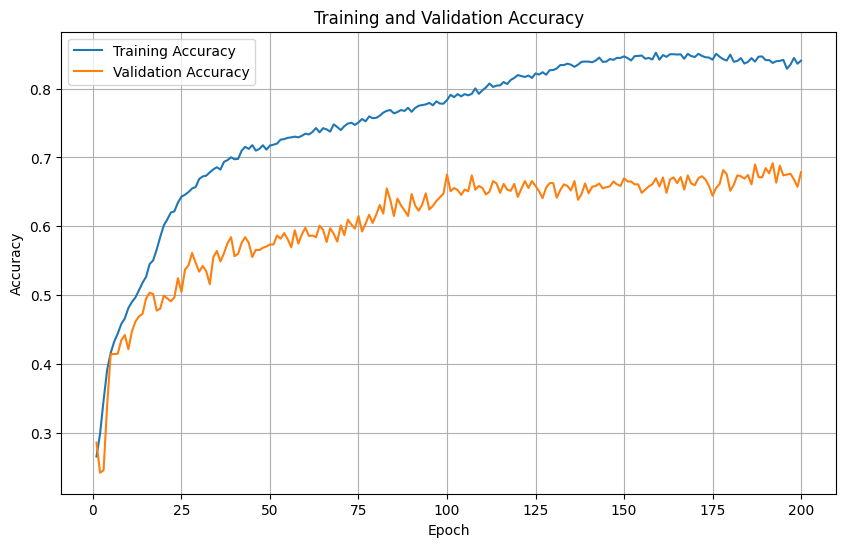

In [43]:
import matplotlib.pyplot as plt
n_epochs = number_epochs
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [44]:
end_time = time.time()
calc_time(end_time, start_time)
test_model(model, test_loader)

time to train model:   0.0 hours,   6.0 minutes,   32 seconds
Test acc: 0.621


In [45]:
torch.save(model, path_to_save+'cnn')
torch.cuda.empty_cache()

## shallow cnn

In [46]:
class TimeDistributed(nn.Module):
    def __init__(self, layer):
        super(TimeDistributed, self).__init__()
        self.layer = layer

    def forward(self, x):
        tmp = x.contiguous().view(-1, x.size(-1))
        y = self.layer(tmp)
        y = y.contiguous().view(x.size(0), -1, y.size(-1))

        return y

In [47]:
class Positional(nn.Module):
    def __init__(self, d_model=200, dropout=0.5, max_len=5000):
        super(Positional, self).__init__()
        self.dropout = nn.Dropout(dropout)

        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pos_encoding = torch.zeros(max_len, 1, d_model)
        pos_encoding[:, 0, 0::2] = torch.sin(position * div_term)
        pos_encoding[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pos_encoding', pos_encoding)

    def forward(self, x):
        x = x + self.pos_encoding[:x.size(1), 0, :].unsqueeze(0).to(device)
        return self.dropout(x)

In [48]:
class Shallow(nn.Module):
    def __init__(self,
                 num_classes=4,
                 hidden_dims=256,
                 dropout=0.6,
                 kernel=4,
                 stride=1,
                 padding=0,
                 pool_kernel=3,
                 time_bins=400,
                 channels=22,
                 depth=25,
                d_model=200,
                nhead=4,
                num_encoder_layers=4):
        super(Shallow, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=channels,
                      out_channels=depth,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding + 6),
            nn.ReLU(),
            nn.BatchNorm1d(depth),
            nn.Dropout(dropout)
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=depth,
                      out_channels=depth * 4,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding),
            nn.ReLU(),
            nn.BatchNorm1d(depth * 4),
            nn.Dropout(dropout)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=depth * 4,
                      out_channels=depth * 8,
                      kernel_size=(1, depth),
                      stride=stride,
                      padding=padding),
            nn.ELU(),
            nn.BatchNorm2d(depth * 8),
            nn.MaxPool2d(kernel_size=(1, pool_kernel)),
            nn.Dropout(dropout),
            nn.Tanh()
        )

        self.flatten = nn.Flatten(start_dim=2)

        self.encoding = Positional(d_model, dropout=0.2)
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, 
                                                    nhead=nhead, 
                                                    dim_feedforward=hidden_dims, 
                                                    dropout=0.2,
                                                   batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, 
                                                         num_layers=num_encoder_layers)

        self.nd = nn.Sequential(
            nn.Linear(in_features=depth * 8, out_features=depth * 4),
            nn.ReLU(),
            nn.BatchNorm1d(depth * 4),
            nn.Dropout(dropout),
        )

        self.dense = nn.Linear(in_features=depth * 4,
                               out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.unsqueeze(2)
        x = self.conv3(x)
        x = x.squeeze(3)
        x = self.flatten(x)
        x = x.transpose(1, 2)
        x = self.encoding(x)
        x = self.transformer_encoder(x)
        x = x[:, -1, :]
        x = self.nd(x)
        x = self.dense(x)

        return F.log_softmax(x, dim=1)

In [49]:
batch_size = 64
torchinfo.summary(Shallow(), input_size=(batch_size, 22, 400))

Layer (type:depth-idx)                        Output Shape              Param #
Shallow                                       [64, 4]                   --
├─Sequential: 1-1                             [64, 25, 409]             --
│    └─Conv1d: 2-1                            [64, 25, 409]             2,225
│    └─ReLU: 2-2                              [64, 25, 409]             --
│    └─BatchNorm1d: 2-3                       [64, 25, 409]             50
│    └─Dropout: 2-4                           [64, 25, 409]             --
├─Sequential: 1-2                             [64, 100, 406]            --
│    └─Conv1d: 2-5                            [64, 100, 406]            10,100
│    └─ReLU: 2-6                              [64, 100, 406]            --
│    └─BatchNorm1d: 2-7                       [64, 100, 406]            200
│    └─Dropout: 2-8                           [64, 100, 406]            --
├─Sequential: 1-3                             [64, 200, 1, 127]         --
│    └─Conv2

In [50]:
model = Shallow().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-5)

In [51]:
start_time = time.time()
train_accuracies, val_accuracies = train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=number_epochs,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

Epoch 1


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.251, Val acc: 0.222, Val loss: 1.423
Epoch 2


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.270, Val acc: 0.237, Val loss: 1.390
Epoch 3


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.279, Val acc: 0.226, Val loss: 1.790
Epoch 4


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.283, Val acc: 0.226, Val loss: 1.405
Epoch 5


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.295, Val acc: 0.235, Val loss: 1.381
Epoch 6


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.312, Val acc: 0.294, Val loss: 1.332
Epoch 7


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.365, Val acc: 0.330, Val loss: 1.368
Epoch 8


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.404, Val acc: 0.404, Val loss: 1.279
Epoch 9


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.429, Val acc: 0.371, Val loss: 1.361
Epoch 10


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.456, Val acc: 0.440, Val loss: 1.325
Epoch 11


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.480, Val acc: 0.423, Val loss: 1.561
Epoch 12


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.497, Val acc: 0.399, Val loss: 1.443
Epoch 13


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.511, Val acc: 0.465, Val loss: 1.303
Epoch 14


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.516, Val acc: 0.486, Val loss: 1.349
Epoch 15


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.538, Val acc: 0.379, Val loss: 1.563
Epoch 16


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.548, Val acc: 0.369, Val loss: 1.750
Epoch 17


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.554, Val acc: 0.459, Val loss: 1.498
Epoch 18


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.573, Val acc: 0.446, Val loss: 1.491
Epoch 19


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.579, Val acc: 0.432, Val loss: 1.479
Epoch 20


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.592, Val acc: 0.483, Val loss: 1.702
Epoch 21


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.609, Val acc: 0.394, Val loss: 1.899
Epoch 22


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.617, Val acc: 0.476, Val loss: 1.882
Epoch 23


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.634, Val acc: 0.432, Val loss: 1.421
Epoch 24


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.651, Val acc: 0.517, Val loss: 1.521
Epoch 25


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.669, Val acc: 0.525, Val loss: 1.590
Epoch 26


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.681, Val acc: 0.545, Val loss: 1.464
Epoch 27


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.705, Val acc: 0.565, Val loss: 1.576
Epoch 28


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.713, Val acc: 0.464, Val loss: 2.276
Epoch 29


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.729, Val acc: 0.514, Val loss: 1.875
Epoch 30


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.743, Val acc: 0.501, Val loss: 2.214
Epoch 31


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.754, Val acc: 0.460, Val loss: 2.377
Epoch 32


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.761, Val acc: 0.540, Val loss: 2.029
Epoch 33


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.773, Val acc: 0.505, Val loss: 2.443
Epoch 34


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.783, Val acc: 0.514, Val loss: 2.288
Epoch 35


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.791, Val acc: 0.496, Val loss: 2.209
Epoch 36


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.796, Val acc: 0.530, Val loss: 2.235
Epoch 37


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.804, Val acc: 0.529, Val loss: 2.182
Epoch 38


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.811, Val acc: 0.529, Val loss: 2.182
Epoch 39


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.817, Val acc: 0.515, Val loss: 2.331
Epoch 40


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.823, Val acc: 0.529, Val loss: 2.196
Epoch 41


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.824, Val acc: 0.521, Val loss: 2.444
Epoch 42


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.835, Val acc: 0.524, Val loss: 2.469
Epoch 43


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.834, Val acc: 0.517, Val loss: 2.555
Epoch 44


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.837, Val acc: 0.537, Val loss: 2.375
Epoch 45


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.839, Val acc: 0.527, Val loss: 2.464
Epoch 46


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.843, Val acc: 0.527, Val loss: 2.509
Epoch 47


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.843, Val acc: 0.535, Val loss: 2.428
Epoch 48


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.845, Val acc: 0.540, Val loss: 2.475
Epoch 49


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.846, Val acc: 0.545, Val loss: 2.400
Epoch 50


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.848, Val acc: 0.542, Val loss: 2.415
Epoch 51


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.846, Val acc: 0.542, Val loss: 2.476
Epoch 52


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.845, Val acc: 0.541, Val loss: 2.432
Epoch 53


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.845, Val acc: 0.535, Val loss: 2.422
Epoch 54


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.849, Val acc: 0.537, Val loss: 2.378
Epoch 55


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.850, Val acc: 0.538, Val loss: 2.420
Epoch 56


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.844, Val acc: 0.522, Val loss: 2.480
Epoch 57


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.847, Val acc: 0.545, Val loss: 2.347
Epoch 58


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.850, Val acc: 0.543, Val loss: 2.318
Epoch 59


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.850, Val acc: 0.544, Val loss: 2.288
Epoch 60


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.850, Val acc: 0.528, Val loss: 2.464
Epoch 61


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.848, Val acc: 0.527, Val loss: 2.350
Epoch 62


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.845, Val acc: 0.534, Val loss: 2.478
Epoch 63


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.844, Val acc: 0.518, Val loss: 2.378
Epoch 64


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.845, Val acc: 0.542, Val loss: 2.024
Epoch 65


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.850, Val acc: 0.523, Val loss: 2.121
Epoch 66


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.850, Val acc: 0.531, Val loss: 2.370
Epoch 67


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.855, Val acc: 0.527, Val loss: 2.279
Epoch 68


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.852, Val acc: 0.529, Val loss: 2.742
Epoch 69


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.853, Val acc: 0.535, Val loss: 2.803
Epoch 70


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.856, Val acc: 0.557, Val loss: 2.319
Epoch 71


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.855, Val acc: 0.541, Val loss: 2.373
Epoch 72


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.855, Val acc: 0.538, Val loss: 1.926
Epoch 73


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.858, Val acc: 0.554, Val loss: 2.161
Epoch 74


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.859, Val acc: 0.551, Val loss: 2.147
Epoch 75


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.860, Val acc: 0.554, Val loss: 2.129
Epoch 76


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.859, Val acc: 0.558, Val loss: 2.044
Epoch 77


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.854, Val acc: 0.489, Val loss: 2.309
Epoch 78


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.864, Val acc: 0.548, Val loss: 1.875
Epoch 79


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.873, Val acc: 0.551, Val loss: 1.853
Epoch 80


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.862, Val acc: 0.574, Val loss: 2.131
Epoch 81


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.875, Val acc: 0.569, Val loss: 1.806
Epoch 82


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.870, Val acc: 0.566, Val loss: 2.195
Epoch 83


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.879, Val acc: 0.549, Val loss: 2.116
Epoch 84


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.879, Val acc: 0.542, Val loss: 2.544
Epoch 85


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.884, Val acc: 0.558, Val loss: 2.358
Epoch 86


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.876, Val acc: 0.597, Val loss: 1.974
Epoch 87


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.885, Val acc: 0.541, Val loss: 2.462
Epoch 88


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.883, Val acc: 0.566, Val loss: 2.232
Epoch 89


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.884, Val acc: 0.562, Val loss: 1.944
Epoch 90


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.889, Val acc: 0.583, Val loss: 2.142
Epoch 91


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.882, Val acc: 0.564, Val loss: 1.744
Epoch 92


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.901, Val acc: 0.565, Val loss: 2.150
Epoch 93


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.885, Val acc: 0.586, Val loss: 2.039
Epoch 94


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.892, Val acc: 0.583, Val loss: 2.203
Epoch 95


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.903, Val acc: 0.547, Val loss: 2.226
Epoch 96


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.908, Val acc: 0.565, Val loss: 2.371
Epoch 97


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.906, Val acc: 0.576, Val loss: 2.200
Epoch 98


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.902, Val acc: 0.571, Val loss: 2.228
Epoch 99


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.915, Val acc: 0.560, Val loss: 2.453
Epoch 100


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.891, Val acc: 0.550, Val loss: 2.442
Epoch 101


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.913, Val acc: 0.581, Val loss: 2.205
Epoch 102


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.920, Val acc: 0.586, Val loss: 2.208
Epoch 103


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.925, Val acc: 0.567, Val loss: 1.832
Epoch 104


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.927, Val acc: 0.550, Val loss: 2.545
Epoch 105


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.931, Val acc: 0.565, Val loss: 2.571
Epoch 106


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.920, Val acc: 0.569, Val loss: 2.421
Epoch 107


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.925, Val acc: 0.544, Val loss: 2.149
Epoch 108


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.931, Val acc: 0.596, Val loss: 1.910
Epoch 109


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.931, Val acc: 0.570, Val loss: 2.498
Epoch 110


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.929, Val acc: 0.573, Val loss: 2.273
Epoch 111


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.945, Val acc: 0.588, Val loss: 2.156
Epoch 112


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.937, Val acc: 0.624, Val loss: 2.347
Epoch 113


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.941, Val acc: 0.597, Val loss: 2.303
Epoch 114


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.950, Val acc: 0.593, Val loss: 2.418
Epoch 115


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.950, Val acc: 0.557, Val loss: 2.434
Epoch 116


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.949, Val acc: 0.602, Val loss: 2.279
Epoch 117


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.951, Val acc: 0.617, Val loss: 2.399
Epoch 118


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.957, Val acc: 0.635, Val loss: 1.928
Epoch 119


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.951, Val acc: 0.608, Val loss: 2.469
Epoch 120


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.961, Val acc: 0.633, Val loss: 2.098
Epoch 121


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.955, Val acc: 0.602, Val loss: 2.153
Epoch 122


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.968, Val acc: 0.616, Val loss: 2.720
Epoch 123


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.968, Val acc: 0.592, Val loss: 2.236
Epoch 124


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.970, Val acc: 0.616, Val loss: 2.307
Epoch 125


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.971, Val acc: 0.597, Val loss: 2.321
Epoch 126


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.973, Val acc: 0.602, Val loss: 2.159
Epoch 127


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.974, Val acc: 0.593, Val loss: 2.166
Epoch 128


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.974, Val acc: 0.590, Val loss: 2.468
Epoch 129


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.978, Val acc: 0.589, Val loss: 2.365
Epoch 130


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.977, Val acc: 0.593, Val loss: 2.275
Epoch 131


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.981, Val acc: 0.590, Val loss: 2.539
Epoch 132


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.983, Val acc: 0.605, Val loss: 2.264
Epoch 133


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.983, Val acc: 0.593, Val loss: 2.383
Epoch 134


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.982, Val acc: 0.564, Val loss: 2.572
Epoch 135


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.985, Val acc: 0.573, Val loss: 2.757
Epoch 136


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.983, Val acc: 0.591, Val loss: 2.793
Epoch 137


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.584, Val loss: 3.013
Epoch 138


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.594, Val loss: 2.738
Epoch 139


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.595, Val loss: 2.806
Epoch 140


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.588, Val loss: 2.712
Epoch 141


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.989, Val acc: 0.584, Val loss: 2.720
Epoch 142


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.585, Val loss: 2.698
Epoch 143


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.991, Val acc: 0.588, Val loss: 2.748
Epoch 144


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.991, Val acc: 0.590, Val loss: 2.795
Epoch 145


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.993, Val acc: 0.582, Val loss: 2.886
Epoch 146


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.992, Val acc: 0.588, Val loss: 2.807
Epoch 147


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.991, Val acc: 0.584, Val loss: 2.751
Epoch 148


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.993, Val acc: 0.584, Val loss: 2.802
Epoch 149


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.993, Val acc: 0.584, Val loss: 2.772
Epoch 150


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.991, Val acc: 0.583, Val loss: 2.782
Epoch 151


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.992, Val acc: 0.584, Val loss: 2.793
Epoch 152


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.993, Val acc: 0.585, Val loss: 2.808
Epoch 153


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.993, Val acc: 0.585, Val loss: 2.797
Epoch 154


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.992, Val acc: 0.589, Val loss: 2.789
Epoch 155


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.992, Val acc: 0.583, Val loss: 2.828
Epoch 156


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.991, Val acc: 0.593, Val loss: 2.897
Epoch 157


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.991, Val acc: 0.591, Val loss: 2.849
Epoch 158


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.992, Val acc: 0.586, Val loss: 2.821
Epoch 159


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.991, Val acc: 0.581, Val loss: 2.876
Epoch 160


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.991, Val acc: 0.591, Val loss: 2.781
Epoch 161


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.992, Val acc: 0.594, Val loss: 2.825
Epoch 162


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.992, Val acc: 0.593, Val loss: 2.921
Epoch 163


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.990, Val acc: 0.580, Val loss: 2.865
Epoch 164


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.989, Val acc: 0.591, Val loss: 2.775
Epoch 165


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.986, Val acc: 0.583, Val loss: 2.602
Epoch 166


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.989, Val acc: 0.563, Val loss: 2.812
Epoch 167


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.990, Val acc: 0.577, Val loss: 2.931
Epoch 168


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.569, Val loss: 3.108
Epoch 169


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.980, Val acc: 0.584, Val loss: 2.692
Epoch 170


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.982, Val acc: 0.559, Val loss: 2.930
Epoch 171


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.982, Val acc: 0.586, Val loss: 2.867
Epoch 172


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.984, Val acc: 0.568, Val loss: 2.863
Epoch 173


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.980, Val acc: 0.577, Val loss: 2.715
Epoch 174


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.963, Val acc: 0.591, Val loss: 2.599
Epoch 175


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.970, Val acc: 0.556, Val loss: 2.317
Epoch 176


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.978, Val acc: 0.590, Val loss: 2.444
Epoch 177


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.979, Val acc: 0.579, Val loss: 2.553
Epoch 178


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.977, Val acc: 0.584, Val loss: 2.836
Epoch 179


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.968, Val acc: 0.568, Val loss: 2.968
Epoch 180


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.966, Val acc: 0.564, Val loss: 2.824
Epoch 181


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.965, Val acc: 0.583, Val loss: 2.679
Epoch 182


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.972, Val acc: 0.590, Val loss: 2.654
Epoch 183


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.973, Val acc: 0.586, Val loss: 2.697
Epoch 184


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.973, Val acc: 0.575, Val loss: 3.107
Epoch 185


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.955, Val acc: 0.570, Val loss: 3.023
Epoch 186


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.967, Val acc: 0.604, Val loss: 2.309
Epoch 187


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.968, Val acc: 0.537, Val loss: 2.979
Epoch 188


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.971, Val acc: 0.562, Val loss: 3.299
Epoch 189


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.960, Val acc: 0.590, Val loss: 2.571
Epoch 190


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.966, Val acc: 0.592, Val loss: 2.401
Epoch 191


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.965, Val acc: 0.588, Val loss: 2.316
Epoch 192


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.962, Val acc: 0.554, Val loss: 2.549
Epoch 193


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.967, Val acc: 0.570, Val loss: 2.563
Epoch 194


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.966, Val acc: 0.588, Val loss: 2.833
Epoch 195


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.960, Val acc: 0.588, Val loss: 2.806
Epoch 196


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.961, Val acc: 0.574, Val loss: 2.662
Epoch 197


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.962, Val acc: 0.610, Val loss: 2.227
Epoch 198


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.970, Val acc: 0.590, Val loss: 2.847
Epoch 199


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.960, Val acc: 0.584, Val loss: 2.438
Epoch 200


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.967, Val acc: 0.568, Val loss: 2.201


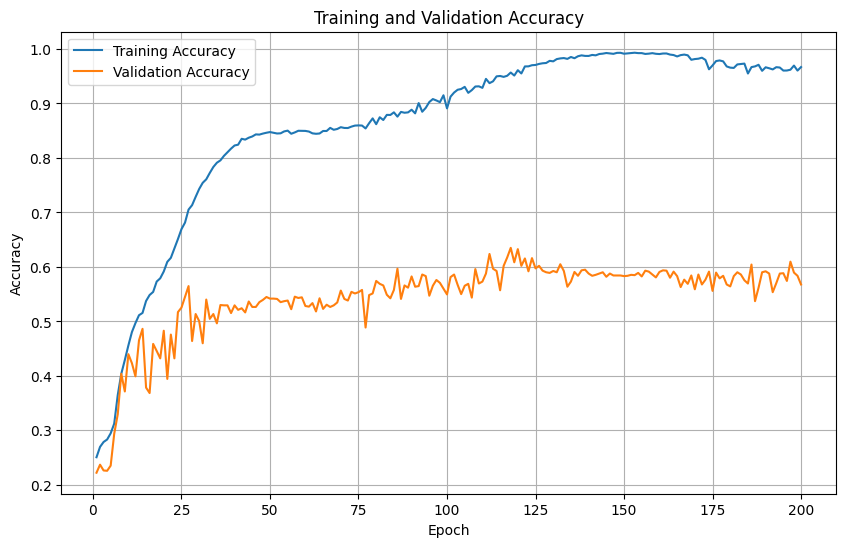

In [52]:
import matplotlib.pyplot as plt
n_epochs = number_epochs
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [53]:
end_time = time.time()
calc_time(end_time, start_time)
test_model(model, test_loader)

time to train model:   0.0 hours,   49.0 minutes,   49 seconds
Test acc: 0.479


In [54]:
torch.save(model, path_to_save+'shallow_cnn')
torch.cuda.empty_cache()

## cnn lstm

In [55]:
class TimeDistributed(nn.Module):
    def __init__(self, layer):
        super(TimeDistributed, self).__init__()
        self.layer = layer

    def forward(self, x):
        tmp = x.contiguous().view(-1, x.size(-1))
        y = self.layer(tmp)
        y = y.contiguous().view(x.size(0), -1, y.size(-1))

        return y

In [56]:
class CNNLSTM(nn.Module):
    def __init__(self,
                 num_classes=4,
                 hidden_dims=256,
                 num_layers=2,
                 dropout=0.5,
                 kernel=3,
                 stride=2,
                 padding=0,
                 pool_kernel=2,
                 time_bins=400,
                 channels=22,
                 depth=25):
        super(CNNLSTM, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=channels,
                      out_channels=depth,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=depth,
                      out_channels=depth * 2,
                      kernel_size=(1, depth),
                      stride=stride,
                      padding=padding),
            nn.ELU(),
            nn.BatchNorm2d(depth * 2),
            nn.MaxPool2d(kernel_size=(1, pool_kernel)),
            nn.Dropout(dropout)
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 2,
                      out_channels=depth * 4,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding + 3),
            nn.ELU(),
            nn.BatchNorm1d(depth * 4),
        )
        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 4,
                      out_channels=depth * 4,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding + 5),
            nn.ELU(),
            nn.BatchNorm1d(depth * 4),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )
        self.conv5 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 4,
                      out_channels=depth * 8,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding),
            nn.ELU(),
            nn.BatchNorm1d(depth * 8),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )

        self.linear = nn.Sequential(
            nn.Linear(in_features=depth * 8,
                      out_features=depth * 8),
            nn.ReLU(),
            nn.BatchNorm1d(depth * 8),
            nn.MaxPool1d(kernel_size=pool_kernel),
        )

        self.lstm1 = nn.LSTM(input_size=depth * 4,
                             hidden_size=depth * 4,
                             num_layers=num_layers,
                             batch_first=True,
                             bidirectional=True)

        self.lstm2 = nn.LSTM(input_size=depth * 8,
                             hidden_size=depth * 4,
                             num_layers=num_layers,
                             batch_first=True,
                             bidirectional=True)

        self.td = nn.Sequential(
            TimeDistributed(nn.Linear(in_features=depth * 8, out_features=depth * 4)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.BatchNorm1d(depth * 4)),
            # TimeDistributed(nn.Dropout(dropout)),
            # TimeDistributed(nn.Linear(in_features=depth * 4, out_features=depth * 2)),
            # TimeDistributed(nn.ReLU()),
            # TimeDistributed(nn.BatchNorm1d(depth * 2)),
            # TimeDistributed(nn.Dropout(dropout)),
        )

        self.dense = nn.Linear(in_features=depth * 4, out_features=num_classes)

        self.nd = nn.Sequential(
            nn.Linear(in_features=depth * 8, out_features=depth * 4),
            nn.ReLU(),
            nn.BatchNorm1d(depth * 4),
            nn.Dropout(dropout),
            # nn.Linear(in_features=depth * 4, out_features=depth * 2),
            # nn.ReLU(),
            # nn.BatchNorm1d(depth * 2),
            # nn.Dropout(dropout),
            # nn.Linear(in_features=depth * 2, out_features=depth),
            # nn.ReLU(),
            # nn.BatchNorm1d(depth),
            # nn.Dropout(dropout),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = x.unsqueeze(2)
        x = self.conv2(x)
        x = x.squeeze(2)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.transpose(1, 2)
        x = x[:, -1, :]
        x = self.linear(x)
        x, _ = self.lstm1(x)
        #x, _ = self.lstm2(x)
        #x = self.td(x)
        x = self.nd(x)
        x = self.dense(x)
        return F.log_softmax(x, dim=1)

In [57]:
batch_size = 128
torchinfo.summary(CNNLSTM(), input_size=(batch_size, 22, 400))

Layer (type:depth-idx)                   Output Shape              Param #
CNNLSTM                                  [128, 4]                  503,500
├─Sequential: 1-1                        [128, 25, 199]            --
│    └─Conv1d: 2-1                       [128, 25, 199]            1,675
│    └─ReLU: 2-2                         [128, 25, 199]            --
├─Sequential: 1-2                        [128, 50, 1, 44]          --
│    └─Conv2d: 2-3                       [128, 50, 1, 88]          31,300
│    └─ELU: 2-4                          [128, 50, 1, 88]          --
│    └─BatchNorm2d: 2-5                  [128, 50, 1, 88]          100
│    └─MaxPool2d: 2-6                    [128, 50, 1, 44]          --
│    └─Dropout: 2-7                      [128, 50, 1, 44]          --
├─Sequential: 1-3                        [128, 100, 24]            --
│    └─Conv1d: 2-8                       [128, 100, 24]            15,100
│    └─ELU: 2-9                          [128, 100, 24]            -

In [58]:
model = CNNLSTM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(model.parameters(), lr=5e-4, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=5e-5)

In [59]:
start_time = time.time()
train_accuracies, val_accuracies = train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=number_epochs,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

Epoch 1


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.250, Val acc: 0.212, Val loss: 1.843
Epoch 2


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.264, Val acc: 0.212, Val loss: 6.208
Epoch 3


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.270, Val acc: 0.212, Val loss: 6.829
Epoch 4


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.304, Val acc: 0.214, Val loss: 5.371
Epoch 5


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.342, Val acc: 0.233, Val loss: 4.330
Epoch 6


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.384, Val acc: 0.246, Val loss: 3.768
Epoch 7


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.443, Val acc: 0.312, Val loss: 2.924
Epoch 8


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.488, Val acc: 0.415, Val loss: 1.902
Epoch 9


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.520, Val acc: 0.350, Val loss: 2.155
Epoch 10


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.554, Val acc: 0.429, Val loss: 1.252
Epoch 11


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.582, Val acc: 0.396, Val loss: 1.367
Epoch 12


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.616, Val acc: 0.477, Val loss: 1.188
Epoch 13


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.640, Val acc: 0.467, Val loss: 1.233
Epoch 14


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.663, Val acc: 0.450, Val loss: 1.185
Epoch 15


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.681, Val acc: 0.445, Val loss: 1.309
Epoch 16


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.701, Val acc: 0.403, Val loss: 1.439
Epoch 17


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.718, Val acc: 0.462, Val loss: 1.252
Epoch 18


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.734, Val acc: 0.449, Val loss: 1.345
Epoch 19


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.752, Val acc: 0.473, Val loss: 1.356
Epoch 20


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.768, Val acc: 0.506, Val loss: 1.354
Epoch 21


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.785, Val acc: 0.488, Val loss: 1.343
Epoch 22


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.793, Val acc: 0.432, Val loss: 1.680
Epoch 23


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.810, Val acc: 0.478, Val loss: 1.436
Epoch 24


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.817, Val acc: 0.485, Val loss: 1.495
Epoch 25


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.823, Val acc: 0.483, Val loss: 1.519
Epoch 26


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.836, Val acc: 0.504, Val loss: 1.551
Epoch 27


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.837, Val acc: 0.484, Val loss: 1.555
Epoch 28


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.856, Val acc: 0.486, Val loss: 1.669
Epoch 29


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.856, Val acc: 0.508, Val loss: 1.588
Epoch 30


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.861, Val acc: 0.531, Val loss: 1.504
Epoch 31


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.866, Val acc: 0.518, Val loss: 1.618
Epoch 32


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.872, Val acc: 0.513, Val loss: 1.588
Epoch 33


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.874, Val acc: 0.505, Val loss: 1.718
Epoch 34


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.879, Val acc: 0.523, Val loss: 1.723
Epoch 35


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.876, Val acc: 0.528, Val loss: 1.655
Epoch 36


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.886, Val acc: 0.528, Val loss: 1.708
Epoch 37


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.886, Val acc: 0.541, Val loss: 1.612
Epoch 38


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.891, Val acc: 0.535, Val loss: 1.649
Epoch 39


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.893, Val acc: 0.532, Val loss: 1.695
Epoch 40


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.892, Val acc: 0.543, Val loss: 1.699
Epoch 41


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.897, Val acc: 0.522, Val loss: 1.676
Epoch 42


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.899, Val acc: 0.522, Val loss: 1.725
Epoch 43


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.898, Val acc: 0.536, Val loss: 1.801
Epoch 44


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.901, Val acc: 0.532, Val loss: 1.769
Epoch 45


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.900, Val acc: 0.527, Val loss: 1.748
Epoch 46


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.903, Val acc: 0.517, Val loss: 1.786
Epoch 47


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.903, Val acc: 0.534, Val loss: 1.784
Epoch 48


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.904, Val acc: 0.532, Val loss: 1.708
Epoch 49


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.908, Val acc: 0.526, Val loss: 1.736
Epoch 50


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.908, Val acc: 0.529, Val loss: 1.815
Epoch 51


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.907, Val acc: 0.532, Val loss: 1.764
Epoch 52


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.908, Val acc: 0.541, Val loss: 1.774
Epoch 53


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.907, Val acc: 0.541, Val loss: 1.732
Epoch 54


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.910, Val acc: 0.527, Val loss: 1.767
Epoch 55


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.913, Val acc: 0.534, Val loss: 1.791
Epoch 56


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.908, Val acc: 0.527, Val loss: 1.794
Epoch 57


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.910, Val acc: 0.530, Val loss: 1.760
Epoch 58


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.910, Val acc: 0.543, Val loss: 1.817
Epoch 59


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.916, Val acc: 0.535, Val loss: 1.792
Epoch 60


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.914, Val acc: 0.532, Val loss: 1.879
Epoch 61


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.912, Val acc: 0.525, Val loss: 1.873
Epoch 62


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.916, Val acc: 0.534, Val loss: 1.924
Epoch 63


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.915, Val acc: 0.519, Val loss: 1.955
Epoch 64


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.912, Val acc: 0.521, Val loss: 1.957
Epoch 65


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.914, Val acc: 0.523, Val loss: 1.844
Epoch 66


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.918, Val acc: 0.525, Val loss: 1.818
Epoch 67


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.914, Val acc: 0.530, Val loss: 1.924
Epoch 68


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.914, Val acc: 0.532, Val loss: 1.990
Epoch 69


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.915, Val acc: 0.552, Val loss: 1.842
Epoch 70


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.916, Val acc: 0.528, Val loss: 2.071
Epoch 71


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.915, Val acc: 0.546, Val loss: 1.867
Epoch 72


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.916, Val acc: 0.538, Val loss: 1.999
Epoch 73


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.915, Val acc: 0.547, Val loss: 1.775
Epoch 74


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.916, Val acc: 0.540, Val loss: 1.895
Epoch 75


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.915, Val acc: 0.557, Val loss: 1.769
Epoch 76


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.914, Val acc: 0.533, Val loss: 2.099
Epoch 77


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.913, Val acc: 0.534, Val loss: 1.963
Epoch 78


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.917, Val acc: 0.528, Val loss: 1.879
Epoch 79


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.913, Val acc: 0.514, Val loss: 2.005
Epoch 80


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.917, Val acc: 0.534, Val loss: 1.770
Epoch 81


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.919, Val acc: 0.541, Val loss: 1.720
Epoch 82


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.920, Val acc: 0.547, Val loss: 1.699
Epoch 83


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.920, Val acc: 0.553, Val loss: 1.803
Epoch 84


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.916, Val acc: 0.538, Val loss: 1.935
Epoch 85


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.919, Val acc: 0.549, Val loss: 1.924
Epoch 86


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.915, Val acc: 0.559, Val loss: 1.799
Epoch 87


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.917, Val acc: 0.536, Val loss: 1.813
Epoch 88


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.918, Val acc: 0.567, Val loss: 1.534
Epoch 89


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.920, Val acc: 0.552, Val loss: 1.708
Epoch 90


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.923, Val acc: 0.548, Val loss: 1.658
Epoch 91


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.925, Val acc: 0.568, Val loss: 1.558
Epoch 92


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.927, Val acc: 0.536, Val loss: 1.754
Epoch 93


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.925, Val acc: 0.570, Val loss: 1.529
Epoch 94


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.920, Val acc: 0.571, Val loss: 1.600
Epoch 95


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.923, Val acc: 0.544, Val loss: 1.909
Epoch 96


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.927, Val acc: 0.548, Val loss: 1.788
Epoch 97


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.926, Val acc: 0.545, Val loss: 1.883
Epoch 98


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.930, Val acc: 0.555, Val loss: 1.920
Epoch 99


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.930, Val acc: 0.547, Val loss: 1.667
Epoch 100


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.930, Val acc: 0.542, Val loss: 1.742
Epoch 101


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.934, Val acc: 0.540, Val loss: 1.884
Epoch 102


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.927, Val acc: 0.546, Val loss: 1.687
Epoch 103


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.932, Val acc: 0.571, Val loss: 1.634
Epoch 104


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.929, Val acc: 0.566, Val loss: 1.564
Epoch 105


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.934, Val acc: 0.557, Val loss: 1.699
Epoch 106


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.940, Val acc: 0.564, Val loss: 1.587
Epoch 107


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.939, Val acc: 0.578, Val loss: 1.757
Epoch 108


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.935, Val acc: 0.568, Val loss: 1.728
Epoch 109


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.940, Val acc: 0.567, Val loss: 1.562
Epoch 110


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.943, Val acc: 0.557, Val loss: 1.669
Epoch 111


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.944, Val acc: 0.566, Val loss: 1.755
Epoch 112


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.946, Val acc: 0.581, Val loss: 1.544
Epoch 113


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.945, Val acc: 0.550, Val loss: 1.701
Epoch 114


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.949, Val acc: 0.549, Val loss: 1.739
Epoch 115


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.950, Val acc: 0.571, Val loss: 1.707
Epoch 116


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.946, Val acc: 0.570, Val loss: 1.658
Epoch 117


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.947, Val acc: 0.600, Val loss: 1.451
Epoch 118


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.952, Val acc: 0.573, Val loss: 1.542
Epoch 119


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.952, Val acc: 0.588, Val loss: 1.587
Epoch 120


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.952, Val acc: 0.570, Val loss: 1.580
Epoch 121


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.952, Val acc: 0.562, Val loss: 1.680
Epoch 122


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.953, Val acc: 0.561, Val loss: 1.692
Epoch 123


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.957, Val acc: 0.583, Val loss: 1.744
Epoch 124


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.960, Val acc: 0.552, Val loss: 1.749
Epoch 125


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.952, Val acc: 0.585, Val loss: 1.521
Epoch 126


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.957, Val acc: 0.567, Val loss: 1.723
Epoch 127


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.958, Val acc: 0.570, Val loss: 1.626
Epoch 128


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.957, Val acc: 0.577, Val loss: 1.603
Epoch 129


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.962, Val acc: 0.585, Val loss: 1.567
Epoch 130


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.965, Val acc: 0.578, Val loss: 1.639
Epoch 131


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.963, Val acc: 0.587, Val loss: 1.692
Epoch 132


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.965, Val acc: 0.567, Val loss: 1.676
Epoch 133


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.966, Val acc: 0.565, Val loss: 1.674
Epoch 134


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.966, Val acc: 0.587, Val loss: 1.652
Epoch 135


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.964, Val acc: 0.559, Val loss: 1.750
Epoch 136


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.967, Val acc: 0.571, Val loss: 1.701
Epoch 137


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.965, Val acc: 0.568, Val loss: 1.660
Epoch 138


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.966, Val acc: 0.574, Val loss: 1.646
Epoch 139


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.965, Val acc: 0.570, Val loss: 1.650
Epoch 140


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.970, Val acc: 0.580, Val loss: 1.655
Epoch 141


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.968, Val acc: 0.584, Val loss: 1.699
Epoch 142


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.968, Val acc: 0.583, Val loss: 1.620
Epoch 143


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.971, Val acc: 0.584, Val loss: 1.639
Epoch 144


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.970, Val acc: 0.572, Val loss: 1.666
Epoch 145


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.968, Val acc: 0.584, Val loss: 1.697
Epoch 146


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.970, Val acc: 0.580, Val loss: 1.680
Epoch 147


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.970, Val acc: 0.573, Val loss: 1.723
Epoch 148


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.972, Val acc: 0.583, Val loss: 1.717
Epoch 149


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.972, Val acc: 0.576, Val loss: 1.711
Epoch 150


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.971, Val acc: 0.583, Val loss: 1.695
Epoch 151


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.973, Val acc: 0.578, Val loss: 1.705
Epoch 152


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.971, Val acc: 0.577, Val loss: 1.704
Epoch 153


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.972, Val acc: 0.578, Val loss: 1.690
Epoch 154


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.972, Val acc: 0.584, Val loss: 1.664
Epoch 155


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.972, Val acc: 0.582, Val loss: 1.668
Epoch 156


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.972, Val acc: 0.581, Val loss: 1.708
Epoch 157


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.972, Val acc: 0.571, Val loss: 1.753
Epoch 158


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.973, Val acc: 0.582, Val loss: 1.706
Epoch 159


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.972, Val acc: 0.575, Val loss: 1.758
Epoch 160


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.972, Val acc: 0.581, Val loss: 1.712
Epoch 161


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.972, Val acc: 0.568, Val loss: 1.800
Epoch 162


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.973, Val acc: 0.585, Val loss: 1.723
Epoch 163


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.972, Val acc: 0.578, Val loss: 1.789
Epoch 164


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.972, Val acc: 0.569, Val loss: 1.778
Epoch 165


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.971, Val acc: 0.573, Val loss: 1.747
Epoch 166


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.972, Val acc: 0.566, Val loss: 1.669
Epoch 167


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.969, Val acc: 0.571, Val loss: 1.752
Epoch 168


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.968, Val acc: 0.551, Val loss: 1.769
Epoch 169


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.971, Val acc: 0.574, Val loss: 1.777
Epoch 170


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.967, Val acc: 0.574, Val loss: 1.820
Epoch 171


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.966, Val acc: 0.572, Val loss: 1.897
Epoch 172


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.966, Val acc: 0.564, Val loss: 1.867
Epoch 173


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.969, Val acc: 0.581, Val loss: 1.883
Epoch 174


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.969, Val acc: 0.572, Val loss: 1.861
Epoch 175


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.967, Val acc: 0.552, Val loss: 1.885
Epoch 176


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.967, Val acc: 0.575, Val loss: 1.685
Epoch 177


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.967, Val acc: 0.559, Val loss: 1.699
Epoch 178


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.965, Val acc: 0.570, Val loss: 1.774
Epoch 179


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.963, Val acc: 0.573, Val loss: 1.840
Epoch 180


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.960, Val acc: 0.580, Val loss: 1.698
Epoch 181


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.958, Val acc: 0.581, Val loss: 1.619
Epoch 182


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.955, Val acc: 0.583, Val loss: 1.507
Epoch 183


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.959, Val acc: 0.567, Val loss: 1.563
Epoch 184


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.960, Val acc: 0.583, Val loss: 1.744
Epoch 185


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.955, Val acc: 0.560, Val loss: 1.802
Epoch 186


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.959, Val acc: 0.580, Val loss: 1.579
Epoch 187


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.963, Val acc: 0.565, Val loss: 1.635
Epoch 188


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.952, Val acc: 0.555, Val loss: 1.777
Epoch 189


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.954, Val acc: 0.548, Val loss: 2.173
Epoch 190


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.953, Val acc: 0.568, Val loss: 1.679
Epoch 191


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.958, Val acc: 0.591, Val loss: 1.674
Epoch 192


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.955, Val acc: 0.562, Val loss: 1.622
Epoch 193


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.956, Val acc: 0.595, Val loss: 1.455
Epoch 194


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.950, Val acc: 0.589, Val loss: 1.629
Epoch 195


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.956, Val acc: 0.610, Val loss: 1.621
Epoch 196


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.954, Val acc: 0.602, Val loss: 1.454
Epoch 197


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.958, Val acc: 0.594, Val loss: 1.431
Epoch 198


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.953, Val acc: 0.601, Val loss: 1.480
Epoch 199


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.957, Val acc: 0.583, Val loss: 1.659
Epoch 200


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.959, Val acc: 0.600, Val loss: 1.525


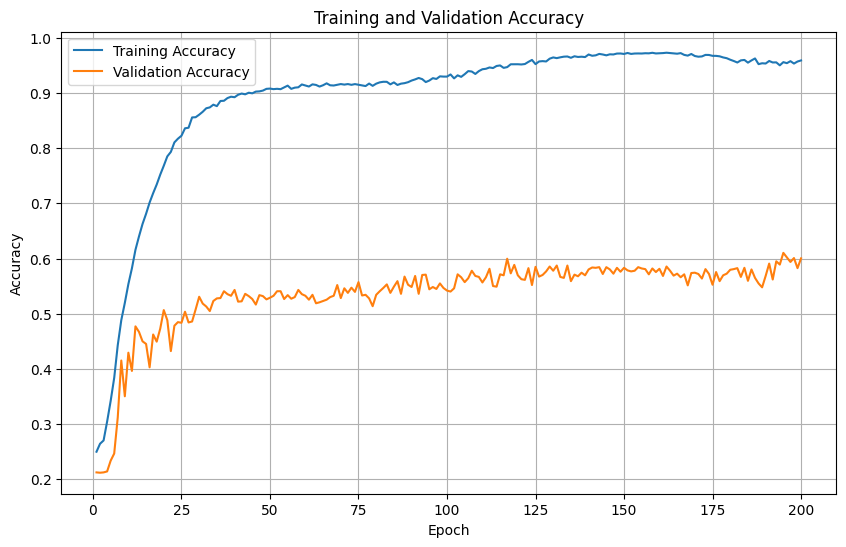

In [60]:
import matplotlib.pyplot as plt
n_epochs = number_epochs
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [61]:
end_time = time.time()
calc_time(end_time, start_time)
test_model(model, test_loader)

time to train model:   0.0 hours,   57.0 minutes,   1 seconds
Test acc: 0.499


In [62]:
torch.save(model, path_to_save+'cnn_lstm')
torch.cuda.empty_cache()

## cnn gru

In [63]:
class TimeDistributed(nn.Module):
    def __init__(self, layer):
        super(TimeDistributed, self).__init__()
        self.layer = layer

    def forward(self, x):
        tmp = x.contiguous().view(-1, x.size(-1))
        y = self.layer(tmp)
        y = y.contiguous().view(x.size(0), -1, y.size(-1))

        return y

In [64]:
class GRU(nn.Module):
    def __init__(self,
                 num_classes=4,
                 hidden_dims=128,
                 num_layers=2,
                 dropout=0.5,
                 kernel=7,
                 stride=1,
                 padding=0,
                 pool_kernel=3,
                 time_bins=400,
                 channels=22,
                 depth=64):
        super(GRU, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=channels,
                      out_channels=depth,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding),
            nn.ReLU(),
            nn.BatchNorm1d(depth),
            nn.Dropout(dropout)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=depth,
                      out_channels=depth * 2,
                      kernel_size=(1, depth),
                      stride=stride,
                      padding=padding),
            nn.ELU(),
            nn.BatchNorm2d(depth * 2),
            nn.MaxPool2d(kernel_size=(1, pool_kernel)),
            nn.Dropout(dropout)
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 2,
                      out_channels=depth * 4,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding + 1),
            nn.ELU(),
            nn.BatchNorm1d(depth * 4),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )
        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 4,
                      out_channels=depth * 4,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding + 3),
            nn.ELU(),
            nn.BatchNorm1d(depth * 4),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )
        self.conv5 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 4,
                      out_channels=depth * 8,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding + 5),
            nn.ELU(),
            nn.BatchNorm1d(depth * 8),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )

        self.nd = nn.Sequential(
            nn.Linear(in_features=depth * 8, out_features=depth * 4),
            nn.ReLU(),
            nn.BatchNorm1d(depth * 4),
            nn.Dropout(dropout),
        )

        self.gru = nn.GRU(input_size=depth * 4,
                           hidden_size=depth * 4,
                           num_layers=num_layers,
                           bias=True,
                           batch_first=True,
                           bidirectional=True)

        self.td = nn.Sequential(
            TimeDistributed(nn.Linear(in_features=depth * 8, out_features=depth * 4)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.BatchNorm1d(depth * 4)),
            TimeDistributed(nn.Dropout(dropout)),
            TimeDistributed(nn.Linear(in_features=depth * 4, out_features=depth * 2)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.BatchNorm1d(depth * 2)),
            TimeDistributed(nn.Dropout(dropout)),
            TimeDistributed(nn.Linear(in_features=depth * 2, out_features=depth)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.BatchNorm1d(depth)),
            TimeDistributed(nn.Dropout(dropout)),
        )
        self.dense = nn.Linear(in_features=depth * 8, out_features=num_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = x.unsqueeze(2)
        x = self.conv2(x)
        x = x.squeeze(2)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.transpose(1, 2)
        x = x[:, -1, :]
        x = self.nd(x)
        x, _ = self.gru(x)
        #x = self.td(x)
        x = self.dense(x)
        return F.log_softmax(x, dim=1)

In [65]:
batch_size = 32
torchinfo.summary(GRU(), input_size=(batch_size, 22, 400))

Layer (type:depth-idx)                   Output Shape              Param #
GRU                                      [32, 4]                   173,376
├─Sequential: 1-1                        [32, 64, 394]             --
│    └─Conv1d: 2-1                       [32, 64, 394]             9,920
│    └─ReLU: 2-2                         [32, 64, 394]             --
│    └─BatchNorm1d: 2-3                  [32, 64, 394]             128
│    └─Dropout: 2-4                      [32, 64, 394]             --
├─Sequential: 1-2                        [32, 128, 1, 110]         --
│    └─Conv2d: 2-5                       [32, 128, 1, 331]         524,416
│    └─ELU: 2-6                          [32, 128, 1, 331]         --
│    └─BatchNorm2d: 2-7                  [32, 128, 1, 331]         256
│    └─MaxPool2d: 2-8                    [32, 128, 1, 110]         --
│    └─Dropout: 2-9                      [32, 128, 1, 110]         --
├─Sequential: 1-3                        [32, 256, 35]             --


In [66]:
model = GRU().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(model.parameters(), lr=0.001, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0.0001)

In [67]:
start_time = time.time()
train_accuracies, val_accuracies = train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=number_epochs,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

Epoch 1


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.261, Val acc: 0.314, Val loss: 1.388
Epoch 2


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.294, Val acc: 0.285, Val loss: 1.386
Epoch 3


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.369, Val acc: 0.320, Val loss: 1.546
Epoch 4


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.435, Val acc: 0.310, Val loss: 1.390
Epoch 5


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.494, Val acc: 0.359, Val loss: 1.393
Epoch 6


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.556, Val acc: 0.363, Val loss: 1.562
Epoch 7


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.611, Val acc: 0.417, Val loss: 1.640
Epoch 8


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.673, Val acc: 0.356, Val loss: 1.505
Epoch 9


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.730, Val acc: 0.305, Val loss: 1.937
Epoch 10


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.764, Val acc: 0.357, Val loss: 1.719
Epoch 11


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.802, Val acc: 0.401, Val loss: 1.631
Epoch 12


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.829, Val acc: 0.362, Val loss: 2.218
Epoch 13


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.853, Val acc: 0.389, Val loss: 1.890
Epoch 14


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.865, Val acc: 0.364, Val loss: 2.030
Epoch 15


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.881, Val acc: 0.354, Val loss: 2.363
Epoch 16


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.895, Val acc: 0.381, Val loss: 2.098
Epoch 17


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.907, Val acc: 0.373, Val loss: 1.995
Epoch 18


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.907, Val acc: 0.380, Val loss: 2.095
Epoch 19


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.918, Val acc: 0.362, Val loss: 2.245
Epoch 20


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.921, Val acc: 0.382, Val loss: 2.198
Epoch 21


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.922, Val acc: 0.376, Val loss: 2.240
Epoch 22


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.925, Val acc: 0.379, Val loss: 2.159
Epoch 23


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.928, Val acc: 0.388, Val loss: 2.133
Epoch 24


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.925, Val acc: 0.383, Val loss: 2.174
Epoch 25


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.925, Val acc: 0.381, Val loss: 2.258
Epoch 26


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.932, Val acc: 0.377, Val loss: 2.260
Epoch 27


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.930, Val acc: 0.358, Val loss: 2.400
Epoch 28


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.929, Val acc: 0.374, Val loss: 2.355
Epoch 29


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.919, Val acc: 0.365, Val loss: 2.051
Epoch 30


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.924, Val acc: 0.366, Val loss: 2.323
Epoch 31


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.922, Val acc: 0.406, Val loss: 2.135
Epoch 32


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.919, Val acc: 0.370, Val loss: 2.315
Epoch 33


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.923, Val acc: 0.350, Val loss: 2.908
Epoch 34


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.910, Val acc: 0.364, Val loss: 2.289
Epoch 35


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.916, Val acc: 0.336, Val loss: 2.160
Epoch 36


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.910, Val acc: 0.356, Val loss: 2.642
Epoch 37


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.910, Val acc: 0.354, Val loss: 2.429
Epoch 38


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.907, Val acc: 0.356, Val loss: 2.123
Epoch 39


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.912, Val acc: 0.388, Val loss: 2.077
Epoch 40


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.913, Val acc: 0.314, Val loss: 2.874
Epoch 41


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.908, Val acc: 0.344, Val loss: 2.833
Epoch 42


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.913, Val acc: 0.379, Val loss: 2.163
Epoch 43


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.927, Val acc: 0.366, Val loss: 2.290
Epoch 44


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.932, Val acc: 0.381, Val loss: 2.207
Epoch 45


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.932, Val acc: 0.369, Val loss: 2.355
Epoch 46


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.933, Val acc: 0.370, Val loss: 2.344
Epoch 47


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.938, Val acc: 0.360, Val loss: 2.347
Epoch 48


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.944, Val acc: 0.386, Val loss: 2.297
Epoch 49


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.948, Val acc: 0.363, Val loss: 2.181
Epoch 50


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.951, Val acc: 0.386, Val loss: 2.170
Epoch 51


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.956, Val acc: 0.399, Val loss: 2.295
Epoch 52


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.956, Val acc: 0.373, Val loss: 2.319
Epoch 53


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.961, Val acc: 0.374, Val loss: 2.297
Epoch 54


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.963, Val acc: 0.388, Val loss: 2.355
Epoch 55


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.968, Val acc: 0.397, Val loss: 2.348
Epoch 56


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.969, Val acc: 0.386, Val loss: 2.454
Epoch 57


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.970, Val acc: 0.393, Val loss: 2.476
Epoch 58


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.973, Val acc: 0.379, Val loss: 2.499
Epoch 59


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.973, Val acc: 0.394, Val loss: 2.409
Epoch 60


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.974, Val acc: 0.392, Val loss: 2.388
Epoch 61


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.976, Val acc: 0.380, Val loss: 2.450
Epoch 62


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.976, Val acc: 0.396, Val loss: 2.415
Epoch 63


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.976, Val acc: 0.390, Val loss: 2.470
Epoch 64


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.978, Val acc: 0.386, Val loss: 2.428
Epoch 65


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.976, Val acc: 0.375, Val loss: 2.549
Epoch 66


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.976, Val acc: 0.390, Val loss: 2.453
Epoch 67


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.972, Val acc: 0.391, Val loss: 2.495
Epoch 68


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.975, Val acc: 0.391, Val loss: 2.502
Epoch 69


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.973, Val acc: 0.373, Val loss: 2.456
Epoch 70


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.968, Val acc: 0.364, Val loss: 2.356
Epoch 71


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.961, Val acc: 0.369, Val loss: 2.458
Epoch 72


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.962, Val acc: 0.361, Val loss: 2.442
Epoch 73


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.954, Val acc: 0.347, Val loss: 2.516
Epoch 74


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.950, Val acc: 0.354, Val loss: 2.478
Epoch 75


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.945, Val acc: 0.354, Val loss: 2.312
Epoch 76


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.941, Val acc: 0.323, Val loss: 2.810
Epoch 77


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.934, Val acc: 0.376, Val loss: 2.497
Epoch 78


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.936, Val acc: 0.381, Val loss: 2.062
Epoch 79


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.940, Val acc: 0.339, Val loss: 2.572
Epoch 80


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.934, Val acc: 0.359, Val loss: 2.342
Epoch 81


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.929, Val acc: 0.344, Val loss: 2.617
Epoch 82


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.937, Val acc: 0.357, Val loss: 2.339
Epoch 83


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.940, Val acc: 0.370, Val loss: 2.224
Epoch 84


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.940, Val acc: 0.410, Val loss: 2.103
Epoch 85


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.935, Val acc: 0.376, Val loss: 2.361
Epoch 86


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.946, Val acc: 0.366, Val loss: 2.271
Epoch 87


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.951, Val acc: 0.350, Val loss: 2.420
Epoch 88


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.952, Val acc: 0.407, Val loss: 2.379
Epoch 89


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.959, Val acc: 0.370, Val loss: 2.612
Epoch 90


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.962, Val acc: 0.384, Val loss: 2.366
Epoch 91


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.965, Val acc: 0.387, Val loss: 2.743
Epoch 92


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.967, Val acc: 0.403, Val loss: 2.657
Epoch 93


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.968, Val acc: 0.390, Val loss: 2.540
Epoch 94


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.972, Val acc: 0.386, Val loss: 2.492
Epoch 95


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.974, Val acc: 0.396, Val loss: 2.450
Epoch 96


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.975, Val acc: 0.392, Val loss: 2.584
Epoch 97


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.980, Val acc: 0.392, Val loss: 2.538
Epoch 98


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.979, Val acc: 0.397, Val loss: 2.562
Epoch 99


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.981, Val acc: 0.381, Val loss: 2.563
Epoch 100


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.980, Val acc: 0.386, Val loss: 2.472
Epoch 101


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.981, Val acc: 0.394, Val loss: 2.537
Epoch 102


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.981, Val acc: 0.393, Val loss: 2.469
Epoch 103


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.981, Val acc: 0.387, Val loss: 2.478
Epoch 104


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.982, Val acc: 0.391, Val loss: 2.597
Epoch 105


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.982, Val acc: 0.379, Val loss: 2.636
Epoch 106


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.982, Val acc: 0.385, Val loss: 2.543
Epoch 107


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.980, Val acc: 0.387, Val loss: 2.644
Epoch 108


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.978, Val acc: 0.381, Val loss: 2.678
Epoch 109


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.977, Val acc: 0.393, Val loss: 2.416
Epoch 110


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.973, Val acc: 0.392, Val loss: 2.533
Epoch 111


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.971, Val acc: 0.361, Val loss: 2.623
Epoch 112


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.967, Val acc: 0.356, Val loss: 2.534
Epoch 113


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.962, Val acc: 0.371, Val loss: 2.215
Epoch 114


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.955, Val acc: 0.358, Val loss: 2.659
Epoch 115


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.952, Val acc: 0.384, Val loss: 2.426
Epoch 116


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.947, Val acc: 0.366, Val loss: 2.353
Epoch 117


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.949, Val acc: 0.396, Val loss: 2.204
Epoch 118


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.946, Val acc: 0.365, Val loss: 2.204
Epoch 119


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.942, Val acc: 0.331, Val loss: 2.578
Epoch 120


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.939, Val acc: 0.338, Val loss: 2.818
Epoch 121


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.941, Val acc: 0.347, Val loss: 2.245
Epoch 122


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.941, Val acc: 0.373, Val loss: 2.216
Epoch 123


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.949, Val acc: 0.347, Val loss: 2.503
Epoch 124


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.946, Val acc: 0.380, Val loss: 2.308
Epoch 125


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.946, Val acc: 0.345, Val loss: 2.800
Epoch 126


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.951, Val acc: 0.355, Val loss: 2.631
Epoch 127


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.955, Val acc: 0.360, Val loss: 2.478
Epoch 128


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.957, Val acc: 0.353, Val loss: 2.517
Epoch 129


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.961, Val acc: 0.373, Val loss: 2.641
Epoch 130


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.962, Val acc: 0.370, Val loss: 2.404
Epoch 131


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.967, Val acc: 0.360, Val loss: 2.567
Epoch 132


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.974, Val acc: 0.372, Val loss: 2.571
Epoch 133


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.972, Val acc: 0.366, Val loss: 2.566
Epoch 134


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.970, Val acc: 0.362, Val loss: 2.426
Epoch 135


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.974, Val acc: 0.356, Val loss: 2.624
Epoch 136


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.977, Val acc: 0.369, Val loss: 2.677
Epoch 137


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.977, Val acc: 0.364, Val loss: 2.638
Epoch 138


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.980, Val acc: 0.366, Val loss: 2.604
Epoch 139


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.983, Val acc: 0.371, Val loss: 2.623
Epoch 140


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.981, Val acc: 0.371, Val loss: 2.684
Epoch 141


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.982, Val acc: 0.371, Val loss: 2.640
Epoch 142


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.983, Val acc: 0.376, Val loss: 2.552
Epoch 143


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.986, Val acc: 0.367, Val loss: 2.656
Epoch 144


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.983, Val acc: 0.377, Val loss: 2.740
Epoch 145


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.984, Val acc: 0.376, Val loss: 2.649
Epoch 146


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.983, Val acc: 0.376, Val loss: 2.658
Epoch 147


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.981, Val acc: 0.377, Val loss: 2.675
Epoch 148


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.982, Val acc: 0.385, Val loss: 2.570
Epoch 149


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.980, Val acc: 0.351, Val loss: 2.839
Epoch 150


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.975, Val acc: 0.380, Val loss: 2.595
Epoch 151


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.971, Val acc: 0.379, Val loss: 2.540
Epoch 152


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.971, Val acc: 0.389, Val loss: 2.405
Epoch 153


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.962, Val acc: 0.341, Val loss: 2.640
Epoch 154


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.956, Val acc: 0.360, Val loss: 2.491
Epoch 155


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.955, Val acc: 0.360, Val loss: 2.603
Epoch 156


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.958, Val acc: 0.338, Val loss: 2.474
Epoch 157


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.952, Val acc: 0.340, Val loss: 2.489
Epoch 158


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.949, Val acc: 0.371, Val loss: 2.285
Epoch 159


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.948, Val acc: 0.391, Val loss: 2.493
Epoch 160


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.944, Val acc: 0.417, Val loss: 1.906
Epoch 161


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.941, Val acc: 0.383, Val loss: 2.224
Epoch 162


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.946, Val acc: 0.366, Val loss: 2.506
Epoch 163


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.947, Val acc: 0.346, Val loss: 2.353
Epoch 164


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.955, Val acc: 0.376, Val loss: 2.190
Epoch 165


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.951, Val acc: 0.369, Val loss: 2.592
Epoch 166


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.953, Val acc: 0.340, Val loss: 2.759
Epoch 167


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.956, Val acc: 0.362, Val loss: 2.713
Epoch 168


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.961, Val acc: 0.348, Val loss: 2.737
Epoch 169


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.960, Val acc: 0.365, Val loss: 2.544
Epoch 170


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.965, Val acc: 0.357, Val loss: 2.404
Epoch 171


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.970, Val acc: 0.375, Val loss: 2.513
Epoch 172


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.972, Val acc: 0.390, Val loss: 2.395
Epoch 173


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.972, Val acc: 0.386, Val loss: 2.466
Epoch 174


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.976, Val acc: 0.365, Val loss: 2.577
Epoch 175


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.978, Val acc: 0.383, Val loss: 2.688
Epoch 176


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.979, Val acc: 0.373, Val loss: 2.761
Epoch 177


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.981, Val acc: 0.395, Val loss: 2.547
Epoch 178


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.981, Val acc: 0.386, Val loss: 2.508
Epoch 179


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.984, Val acc: 0.384, Val loss: 2.592
Epoch 180


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.982, Val acc: 0.387, Val loss: 2.604
Epoch 181


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.984, Val acc: 0.394, Val loss: 2.629
Epoch 182


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.986, Val acc: 0.387, Val loss: 2.631
Epoch 183


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.985, Val acc: 0.380, Val loss: 2.717
Epoch 184


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.986, Val acc: 0.400, Val loss: 2.576
Epoch 185


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.986, Val acc: 0.389, Val loss: 2.650
Epoch 186


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.986, Val acc: 0.390, Val loss: 2.716
Epoch 187


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.985, Val acc: 0.396, Val loss: 2.548
Epoch 188


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.981, Val acc: 0.392, Val loss: 2.644
Epoch 189


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.979, Val acc: 0.370, Val loss: 2.690
Epoch 190


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.978, Val acc: 0.384, Val loss: 2.795
Epoch 191


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.969, Val acc: 0.380, Val loss: 2.474
Epoch 192


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.971, Val acc: 0.362, Val loss: 2.595
Epoch 193


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.966, Val acc: 0.364, Val loss: 2.614
Epoch 194


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.962, Val acc: 0.376, Val loss: 2.433
Epoch 195


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.960, Val acc: 0.363, Val loss: 2.494
Epoch 196


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.955, Val acc: 0.348, Val loss: 2.724
Epoch 197


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.952, Val acc: 0.354, Val loss: 2.655
Epoch 198


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.949, Val acc: 0.318, Val loss: 2.677
Epoch 199


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.947, Val acc: 0.383, Val loss: 2.327
Epoch 200


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.945, Val acc: 0.333, Val loss: 2.587


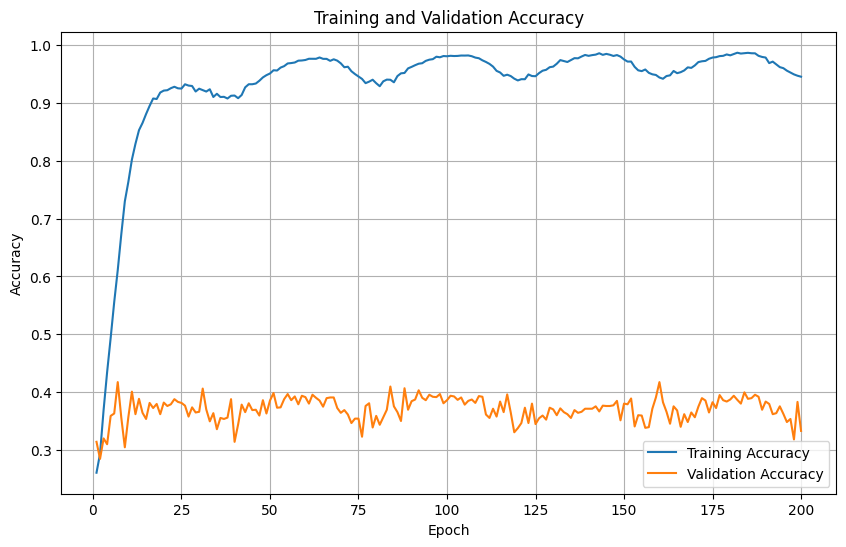

In [68]:
import matplotlib.pyplot as plt
n_epochs = number_epochs
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [69]:
end_time = time.time()
calc_time(end_time, start_time)
test_model(model, test_loader)

time to train model:   1.0 hours,   20.0 minutes,   58 seconds
Test acc: 0.388


In [70]:
torch.save(model, path_to_save+'cnn_gru')
torch.cuda.empty_cache()

## lstm-lstm

In [71]:
class LSTM_LSTM(nn.Module):
    def __init__(self,
                 input_size = 22,
                 hidden_size = 64,
                 num_layers = 2,
                 output_size = 54,
                 num_classes = 4):
        super(LSTM_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # First LSTM layer
        self.lstm1 = nn.LSTM(input_size,
                             hidden_size,
                             num_layers,
                             batch_first=True,
                             bidirectional=True)

        # Second LSTM layer
        self.lstm2 = nn.LSTM(hidden_size * 2,
                             hidden_size,
                             num_layers,
                             batch_first=True,
                             bidirectional=True)


        # Output layer
        self.linear = nn.Linear(hidden_size * 2, output_size)
        self.fc = nn.Sequential(
            nn.Linear(output_size, output_size-10),
            nn.BatchNorm1d(num_features=output_size-10, eps=1e-05, momentum=0.2, affine=True),
            nn.ReLU(inplace = True),
            nn.Linear(output_size-10, num_classes)
        )

    def forward(self, x):
        x = x.transpose(1, 2)

        # Forward pass through LSTM1
        out, _ = self.lstm1(x)

        # Forward pass through LSTM2
        out, _ = self.lstm2(out)

        # fc layer
        out = self.linear(out[:, -1, :])
        return out


In [72]:
batch_size = 64
torchinfo.summary(LSTM_LSTM(), input_size=(batch_size, 22, 400))

Layer (type:depth-idx)                   Output Shape              Param #
LSTM_LSTM                                [64, 54]                  2,688
├─LSTM: 1-1                              [64, 400, 128]            144,384
├─LSTM: 1-2                              [64, 400, 128]            198,656
├─Linear: 1-3                            [64, 54]                  6,966
Total params: 352,694
Trainable params: 352,694
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 8.78
Input size (MB): 2.25
Forward/backward pass size (MB): 52.46
Params size (MB): 1.40
Estimated Total Size (MB): 56.11

In [73]:
model = LSTM_LSTM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0.0001)

In [74]:
start_time = time.time()
train_accuracies, val_accuracies = train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=number_epochs,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

Epoch 1


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.243, Val acc: 0.269, Val loss: 1.397
Epoch 2


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.250, Val acc: 0.292, Val loss: 1.388
Epoch 3


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.255, Val acc: 0.212, Val loss: 1.398
Epoch 4


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.252, Val acc: 0.213, Val loss: 1.391
Epoch 5


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.248, Val acc: 0.212, Val loss: 1.396
Epoch 6


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.258, Val acc: 0.226, Val loss: 1.389
Epoch 7


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.248, Val acc: 0.212, Val loss: 1.403
Epoch 8


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.255, Val acc: 0.292, Val loss: 1.386
Epoch 9


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.251, Val acc: 0.230, Val loss: 1.393
Epoch 10


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.252, Val acc: 0.212, Val loss: 1.410
Epoch 11


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.248, Val acc: 0.212, Val loss: 1.394
Epoch 12


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.256, Val acc: 0.269, Val loss: 1.385
Epoch 13


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.260, Val acc: 0.212, Val loss: 1.396
Epoch 14


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.259, Val acc: 0.226, Val loss: 1.390
Epoch 15


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.269, Val acc: 0.226, Val loss: 1.392
Epoch 16


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.271, Val acc: 0.205, Val loss: 1.404
Epoch 17


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.285, Val acc: 0.228, Val loss: 1.407
Epoch 18


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.292, Val acc: 0.225, Val loss: 1.409
Epoch 19


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.298, Val acc: 0.227, Val loss: 1.395
Epoch 20


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.300, Val acc: 0.235, Val loss: 1.405
Epoch 21


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.311, Val acc: 0.242, Val loss: 1.400
Epoch 22


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.316, Val acc: 0.244, Val loss: 1.402
Epoch 23


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.323, Val acc: 0.223, Val loss: 1.402
Epoch 24


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.323, Val acc: 0.228, Val loss: 1.409
Epoch 25


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.331, Val acc: 0.227, Val loss: 1.406
Epoch 26


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.347, Val acc: 0.233, Val loss: 1.430
Epoch 27


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.362, Val acc: 0.241, Val loss: 1.450
Epoch 28


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.368, Val acc: 0.242, Val loss: 1.469
Epoch 29


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.386, Val acc: 0.255, Val loss: 1.585
Epoch 30


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.380, Val acc: 0.235, Val loss: 1.517
Epoch 31


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.418, Val acc: 0.238, Val loss: 1.515
Epoch 32


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.443, Val acc: 0.261, Val loss: 1.543
Epoch 33


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.466, Val acc: 0.248, Val loss: 1.730
Epoch 34


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.477, Val acc: 0.257, Val loss: 1.691
Epoch 35


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.505, Val acc: 0.253, Val loss: 1.690
Epoch 36


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.539, Val acc: 0.235, Val loss: 1.817
Epoch 37


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.560, Val acc: 0.238, Val loss: 1.868
Epoch 38


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.576, Val acc: 0.238, Val loss: 1.863
Epoch 39


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.618, Val acc: 0.269, Val loss: 1.968
Epoch 40


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.622, Val acc: 0.225, Val loss: 2.065
Epoch 41


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.661, Val acc: 0.250, Val loss: 2.010
Epoch 42


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.681, Val acc: 0.244, Val loss: 2.136
Epoch 43


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.708, Val acc: 0.232, Val loss: 2.367
Epoch 44


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.733, Val acc: 0.233, Val loss: 2.568
Epoch 45


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.752, Val acc: 0.218, Val loss: 2.567
Epoch 46


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.763, Val acc: 0.255, Val loss: 2.598
Epoch 47


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.808, Val acc: 0.239, Val loss: 2.756
Epoch 48


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.827, Val acc: 0.232, Val loss: 2.875
Epoch 49


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.838, Val acc: 0.261, Val loss: 3.052
Epoch 50


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.863, Val acc: 0.244, Val loss: 3.331
Epoch 51


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.873, Val acc: 0.225, Val loss: 3.488
Epoch 52


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.891, Val acc: 0.255, Val loss: 3.472
Epoch 53


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.910, Val acc: 0.238, Val loss: 3.600
Epoch 54


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.932, Val acc: 0.251, Val loss: 3.702
Epoch 55


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.944, Val acc: 0.244, Val loss: 3.873
Epoch 56


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.958, Val acc: 0.247, Val loss: 3.908
Epoch 57


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.961, Val acc: 0.247, Val loss: 3.912
Epoch 58


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.967, Val acc: 0.253, Val loss: 4.001
Epoch 59


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.976, Val acc: 0.245, Val loss: 4.111
Epoch 60


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.981, Val acc: 0.249, Val loss: 4.180
Epoch 61


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.983, Val acc: 0.248, Val loss: 4.202
Epoch 62


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.983, Val acc: 0.251, Val loss: 4.251
Epoch 63


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.982, Val acc: 0.246, Val loss: 4.392
Epoch 64


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.981, Val acc: 0.249, Val loss: 4.335
Epoch 65


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.980, Val acc: 0.258, Val loss: 4.346
Epoch 66


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.970, Val acc: 0.245, Val loss: 4.262
Epoch 67


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.945, Val acc: 0.252, Val loss: 4.187
Epoch 68


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.951, Val acc: 0.241, Val loss: 4.184
Epoch 69


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.928, Val acc: 0.256, Val loss: 4.076
Epoch 70


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.953, Val acc: 0.245, Val loss: 4.113
Epoch 71


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.939, Val acc: 0.246, Val loss: 4.092
Epoch 72


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.928, Val acc: 0.249, Val loss: 4.114
Epoch 73


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.930, Val acc: 0.252, Val loss: 4.026
Epoch 74


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.935, Val acc: 0.241, Val loss: 3.883
Epoch 75


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.919, Val acc: 0.253, Val loss: 4.177
Epoch 76


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.929, Val acc: 0.242, Val loss: 3.997
Epoch 77


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.934, Val acc: 0.231, Val loss: 4.293
Epoch 78


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.924, Val acc: 0.245, Val loss: 4.147
Epoch 79


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.899, Val acc: 0.254, Val loss: 3.878
Epoch 80


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.941, Val acc: 0.246, Val loss: 4.303
Epoch 81


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.922, Val acc: 0.251, Val loss: 3.954
Epoch 82


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.944, Val acc: 0.251, Val loss: 4.286
Epoch 83


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.949, Val acc: 0.258, Val loss: 4.349
Epoch 84


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.950, Val acc: 0.235, Val loss: 4.326
Epoch 85


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.953, Val acc: 0.237, Val loss: 4.435
Epoch 86


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.962, Val acc: 0.241, Val loss: 4.491
Epoch 87


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.950, Val acc: 0.255, Val loss: 4.469
Epoch 88


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.968, Val acc: 0.254, Val loss: 4.640
Epoch 89


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.966, Val acc: 0.242, Val loss: 4.738
Epoch 90


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.982, Val acc: 0.249, Val loss: 4.842
Epoch 91


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.982, Val acc: 0.242, Val loss: 4.838
Epoch 92


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.994, Val acc: 0.242, Val loss: 4.958
Epoch 93


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.996, Val acc: 0.238, Val loss: 5.102
Epoch 94


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.998, Val acc: 0.244, Val loss: 5.088
Epoch 95


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.999, Val acc: 0.244, Val loss: 5.099
Epoch 96


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.999, Val acc: 0.247, Val loss: 5.117
Epoch 97


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.999, Val acc: 0.246, Val loss: 5.102
Epoch 98


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.999, Val acc: 0.251, Val loss: 5.108
Epoch 99


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.999, Val acc: 0.248, Val loss: 5.109
Epoch 100


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.999, Val acc: 0.249, Val loss: 5.108
Epoch 101


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.999, Val acc: 0.249, Val loss: 5.114
Epoch 102


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.999, Val acc: 0.248, Val loss: 5.103
Epoch 103


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.999, Val acc: 0.248, Val loss: 5.099
Epoch 104


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.999, Val acc: 0.246, Val loss: 5.114
Epoch 105


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.999, Val acc: 0.244, Val loss: 5.156
Epoch 106


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.999, Val acc: 0.238, Val loss: 5.081
Epoch 107


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.999, Val acc: 0.241, Val loss: 5.136
Epoch 108


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.999, Val acc: 0.241, Val loss: 5.126
Epoch 109


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.999, Val acc: 0.241, Val loss: 5.142
Epoch 110


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.975, Val acc: 0.243, Val loss: 4.190
Epoch 111


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.937, Val acc: 0.229, Val loss: 4.482
Epoch 112


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.949, Val acc: 0.242, Val loss: 4.373
Epoch 113


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.953, Val acc: 0.248, Val loss: 4.337
Epoch 114


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.947, Val acc: 0.232, Val loss: 4.714
Epoch 115


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.927, Val acc: 0.251, Val loss: 4.336
Epoch 116


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.942, Val acc: 0.245, Val loss: 4.376
Epoch 117


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.953, Val acc: 0.252, Val loss: 4.276
Epoch 118


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.953, Val acc: 0.244, Val loss: 4.648
Epoch 119


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.954, Val acc: 0.244, Val loss: 4.569
Epoch 120


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.947, Val acc: 0.253, Val loss: 4.515
Epoch 121


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.945, Val acc: 0.245, Val loss: 4.634
Epoch 122


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.967, Val acc: 0.235, Val loss: 4.698
Epoch 123


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.968, Val acc: 0.240, Val loss: 4.637
Epoch 124


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.964, Val acc: 0.230, Val loss: 4.710
Epoch 125


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.969, Val acc: 0.234, Val loss: 4.556
Epoch 126


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.974, Val acc: 0.232, Val loss: 5.007
Epoch 127


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.977, Val acc: 0.232, Val loss: 4.867
Epoch 128


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.977, Val acc: 0.225, Val loss: 4.850
Epoch 129


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.248, Val loss: 5.029
Epoch 130


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.992, Val acc: 0.241, Val loss: 5.398
Epoch 131


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.996, Val acc: 0.240, Val loss: 5.225
Epoch 132


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.998, Val acc: 0.237, Val loss: 5.272
Epoch 133


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.999, Val acc: 0.239, Val loss: 5.364
Epoch 134


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 1.000, Val acc: 0.237, Val loss: 5.355
Epoch 135


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 1.000, Val acc: 0.244, Val loss: 5.338
Epoch 136


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 1.000, Val acc: 0.245, Val loss: 5.345
Epoch 137


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 1.000, Val acc: 0.246, Val loss: 5.343
Epoch 138


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 1.000, Val acc: 0.246, Val loss: 5.346
Epoch 139


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 1.000, Val acc: 0.246, Val loss: 5.357
Epoch 140


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 1.000, Val acc: 0.245, Val loss: 5.351
Epoch 141


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 1.000, Val acc: 0.245, Val loss: 5.353
Epoch 142


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 1.000, Val acc: 0.245, Val loss: 5.355
Epoch 143


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 1.000, Val acc: 0.244, Val loss: 5.355
Epoch 144


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 1.000, Val acc: 0.245, Val loss: 5.364
Epoch 145


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 1.000, Val acc: 0.246, Val loss: 5.362
Epoch 146


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 1.000, Val acc: 0.247, Val loss: 5.375
Epoch 147


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 1.000, Val acc: 0.247, Val loss: 5.373
Epoch 148


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 1.000, Val acc: 0.246, Val loss: 5.402
Epoch 149


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 1.000, Val acc: 0.246, Val loss: 5.350
Epoch 150


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 1.000, Val acc: 0.248, Val loss: 5.322
Epoch 151


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.956, Val acc: 0.246, Val loss: 4.361
Epoch 152


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.950, Val acc: 0.245, Val loss: 4.695
Epoch 153


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.961, Val acc: 0.239, Val loss: 4.693
Epoch 154


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.952, Val acc: 0.236, Val loss: 4.771
Epoch 155


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.957, Val acc: 0.265, Val loss: 4.677
Epoch 156


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.960, Val acc: 0.226, Val loss: 4.778
Epoch 157


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.967, Val acc: 0.242, Val loss: 4.859
Epoch 158


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.967, Val acc: 0.242, Val loss: 4.492
Epoch 159


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.963, Val acc: 0.238, Val loss: 4.664
Epoch 160


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.965, Val acc: 0.244, Val loss: 4.420
Epoch 161


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.969, Val acc: 0.227, Val loss: 4.448
Epoch 162


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.966, Val acc: 0.246, Val loss: 5.001
Epoch 163


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.971, Val acc: 0.257, Val loss: 4.845
Epoch 164


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.968, Val acc: 0.241, Val loss: 4.512
Epoch 165


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.971, Val acc: 0.247, Val loss: 5.000
Epoch 166


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.986, Val acc: 0.251, Val loss: 4.930
Epoch 167


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.254, Val loss: 5.065
Epoch 168


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.992, Val acc: 0.248, Val loss: 5.126
Epoch 169


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.991, Val acc: 0.251, Val loss: 5.215
Epoch 170


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.989, Val acc: 0.240, Val loss: 5.232
Epoch 171


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.997, Val acc: 0.243, Val loss: 5.300
Epoch 172


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.999, Val acc: 0.240, Val loss: 5.345
Epoch 173


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 1.000, Val acc: 0.242, Val loss: 5.400
Epoch 174


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 1.000, Val acc: 0.240, Val loss: 5.402
Epoch 175


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 1.000, Val acc: 0.242, Val loss: 5.392
Epoch 176


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 1.000, Val acc: 0.243, Val loss: 5.382
Epoch 177


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 1.000, Val acc: 0.243, Val loss: 5.360
Epoch 178


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 1.000, Val acc: 0.243, Val loss: 5.371
Epoch 179


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 1.000, Val acc: 0.245, Val loss: 5.375
Epoch 180


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 1.000, Val acc: 0.246, Val loss: 5.361
Epoch 181


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 1.000, Val acc: 0.248, Val loss: 5.365
Epoch 182


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 1.000, Val acc: 0.245, Val loss: 5.359
Epoch 183


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 1.000, Val acc: 0.246, Val loss: 5.348
Epoch 184


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 1.000, Val acc: 0.245, Val loss: 5.352
Epoch 185


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 1.000, Val acc: 0.246, Val loss: 5.352
Epoch 186


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 1.000, Val acc: 0.246, Val loss: 5.356
Epoch 187


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 1.000, Val acc: 0.247, Val loss: 5.383
Epoch 188


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 1.000, Val acc: 0.249, Val loss: 5.373
Epoch 189


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 1.000, Val acc: 0.251, Val loss: 5.355
Epoch 190


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 1.000, Val acc: 0.247, Val loss: 5.324
Epoch 191


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 1.000, Val acc: 0.252, Val loss: 5.322
Epoch 192


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.997, Val acc: 0.255, Val loss: 5.130
Epoch 193


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.930, Val acc: 0.243, Val loss: 4.729
Epoch 194


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.958, Val acc: 0.240, Val loss: 4.584
Epoch 195


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.947, Val acc: 0.267, Val loss: 3.834
Epoch 196


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.961, Val acc: 0.235, Val loss: 4.949
Epoch 197


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.965, Val acc: 0.254, Val loss: 4.538
Epoch 198


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.964, Val acc: 0.237, Val loss: 4.895
Epoch 199


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.949, Val acc: 0.248, Val loss: 4.735
Epoch 200


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.969, Val acc: 0.241, Val loss: 4.757


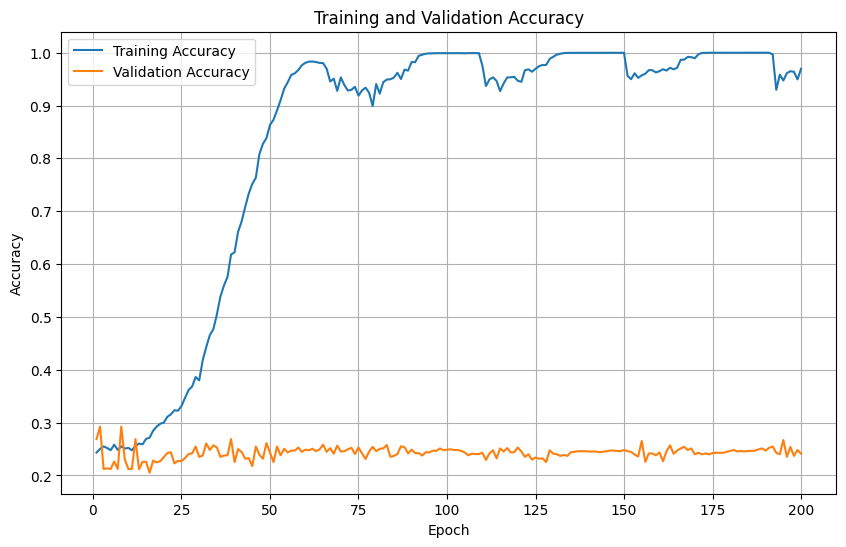

In [75]:
axPool1d: 2-14                   [128, 100, 8]             --
│    └─Dropouimport matplotlib.pyplot as plt
n_epochs = number_epochs
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [76]:
end_time = time.time()
calc_time(end_time, start_time)
test_model(model, test_loader)

time to train model:   1.0 hours,   35.0 minutes,   8 seconds
Test acc: 0.298


In [77]:
torch.save(model, path_to_save+'lstm_lstm')
torch.cuda.empty_cache()

## gru

In [78]:
class GRU(nn.Module):
    def __init__(self,
                 input_size = 22,
                 hidden_size = 64,
                 num_layers = 3,
                 output_size = 54,
                 num_classes = 4):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # GRU Layer
        self.gru = nn.GRU(input_size, hidden_size, num_layers, dropout=dropout, bidirectional=True)

        # Output layer
        self.linear = nn.Linear(hidden_size * 2, output_size)
        self.fc = nn.Sequential(
            nn.Linear(output_size, output_size-10),
            nn.BatchNorm1d(num_features=output_size-10, eps=1e-05, momentum=0.2, affine=True),
            nn.ReLU(inplace = True),
            nn.Linear(output_size-10, num_classes)
        )

    def forward(self, x):
        x = x.transpose(1, 2)

        # Forward pass through GRU
        out, _ = self.gru(x)

        # fc layer
        out = self.linear(out[:, -1, :])
        return out


In [79]:
batch_size = 64
torchinfo.summary(GRU(), input_size=(batch_size, 22, 400))

Layer (type:depth-idx)                   Output Shape              Param #
GRU                                      [64, 54]                  2,688
├─GRU: 1-1                               [64, 400, 128]            182,784
├─Linear: 1-2                            [64, 54]                  6,966
Total params: 192,438
Trainable params: 192,438
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 4.68
Input size (MB): 2.25
Forward/backward pass size (MB): 26.24
Params size (MB): 0.76
Estimated Total Size (MB): 29.25

In [80]:
model = GRU().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0.0001)

In [81]:
start_time = time.time()
train_accuracies, val_accuracies = train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=number_epochs,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

Epoch 1


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.252, Val acc: 0.269, Val loss: 1.387
Epoch 2


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.256, Val acc: 0.225, Val loss: 1.395
Epoch 3


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.254, Val acc: 0.226, Val loss: 1.388
Epoch 4


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.256, Val acc: 0.213, Val loss: 1.397
Epoch 5


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.249, Val acc: 0.231, Val loss: 1.389
Epoch 6


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.255, Val acc: 0.219, Val loss: 1.394
Epoch 7


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.255, Val acc: 0.269, Val loss: 1.398
Epoch 8


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.251, Val acc: 0.294, Val loss: 1.381
Epoch 9


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.248, Val acc: 0.290, Val loss: 1.383
Epoch 10


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.254, Val acc: 0.293, Val loss: 1.389
Epoch 11


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.255, Val acc: 0.222, Val loss: 1.395
Epoch 12


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.261, Val acc: 0.223, Val loss: 1.400
Epoch 13


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.262, Val acc: 0.208, Val loss: 1.397
Epoch 14


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.259, Val acc: 0.267, Val loss: 1.394
Epoch 15


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.260, Val acc: 0.214, Val loss: 1.399
Epoch 16


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.259, Val acc: 0.268, Val loss: 1.400
Epoch 17


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.262, Val acc: 0.208, Val loss: 1.399
Epoch 18


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.263, Val acc: 0.225, Val loss: 1.398
Epoch 19


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.264, Val acc: 0.207, Val loss: 1.409
Epoch 20


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.269, Val acc: 0.254, Val loss: 1.401
Epoch 21


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.271, Val acc: 0.229, Val loss: 1.406
Epoch 22


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.272, Val acc: 0.228, Val loss: 1.411
Epoch 23


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.276, Val acc: 0.233, Val loss: 1.408
Epoch 24


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.268, Val acc: 0.235, Val loss: 1.411
Epoch 25


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.268, Val acc: 0.226, Val loss: 1.409
Epoch 26


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.277, Val acc: 0.261, Val loss: 1.408
Epoch 27


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.277, Val acc: 0.244, Val loss: 1.418
Epoch 28


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.278, Val acc: 0.230, Val loss: 1.415
Epoch 29


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.278, Val acc: 0.255, Val loss: 1.410
Epoch 30


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.279, Val acc: 0.246, Val loss: 1.409
Epoch 31


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.278, Val acc: 0.236, Val loss: 1.412
Epoch 32


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.281, Val acc: 0.262, Val loss: 1.425
Epoch 33


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.283, Val acc: 0.237, Val loss: 1.413
Epoch 34


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.287, Val acc: 0.233, Val loss: 1.429
Epoch 35


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.290, Val acc: 0.223, Val loss: 1.450
Epoch 36


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.290, Val acc: 0.231, Val loss: 1.445
Epoch 37


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.300, Val acc: 0.235, Val loss: 1.452
Epoch 38


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.302, Val acc: 0.259, Val loss: 1.457
Epoch 39


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.302, Val acc: 0.265, Val loss: 1.420
Epoch 40


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.309, Val acc: 0.255, Val loss: 1.458
Epoch 41


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.309, Val acc: 0.264, Val loss: 1.443
Epoch 42


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.325, Val acc: 0.274, Val loss: 1.430
Epoch 43


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.326, Val acc: 0.253, Val loss: 1.441
Epoch 44


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.330, Val acc: 0.249, Val loss: 1.475
Epoch 45


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.331, Val acc: 0.288, Val loss: 1.456
Epoch 46


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.330, Val acc: 0.271, Val loss: 1.469
Epoch 47


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.342, Val acc: 0.299, Val loss: 1.453
Epoch 48


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.346, Val acc: 0.264, Val loss: 1.480
Epoch 49


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.353, Val acc: 0.288, Val loss: 1.441
Epoch 50


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.354, Val acc: 0.298, Val loss: 1.438
Epoch 51


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.359, Val acc: 0.294, Val loss: 1.444
Epoch 52


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.367, Val acc: 0.281, Val loss: 1.452
Epoch 53


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.369, Val acc: 0.294, Val loss: 1.472
Epoch 54


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.372, Val acc: 0.291, Val loss: 1.446
Epoch 55


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.371, Val acc: 0.294, Val loss: 1.460
Epoch 56


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.380, Val acc: 0.308, Val loss: 1.455
Epoch 57


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.377, Val acc: 0.298, Val loss: 1.470
Epoch 58


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.384, Val acc: 0.292, Val loss: 1.475
Epoch 59


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.381, Val acc: 0.296, Val loss: 1.470
Epoch 60


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.389, Val acc: 0.290, Val loss: 1.475
Epoch 61


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.385, Val acc: 0.301, Val loss: 1.473
Epoch 62


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.385, Val acc: 0.292, Val loss: 1.473
Epoch 63


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.391, Val acc: 0.297, Val loss: 1.467
Epoch 64


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.387, Val acc: 0.292, Val loss: 1.478
Epoch 65


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.385, Val acc: 0.290, Val loss: 1.469
Epoch 66


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.387, Val acc: 0.289, Val loss: 1.474
Epoch 67


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.390, Val acc: 0.297, Val loss: 1.482
Epoch 68


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.380, Val acc: 0.293, Val loss: 1.494
Epoch 69


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.390, Val acc: 0.301, Val loss: 1.475
Epoch 70


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.388, Val acc: 0.304, Val loss: 1.472
Epoch 71


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.387, Val acc: 0.292, Val loss: 1.480
Epoch 72


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.385, Val acc: 0.284, Val loss: 1.469
Epoch 73


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.383, Val acc: 0.273, Val loss: 1.473
Epoch 74


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.385, Val acc: 0.305, Val loss: 1.466
Epoch 75


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.385, Val acc: 0.297, Val loss: 1.482
Epoch 76


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.387, Val acc: 0.271, Val loss: 1.515
Epoch 77


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.385, Val acc: 0.281, Val loss: 1.506
Epoch 78


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.386, Val acc: 0.295, Val loss: 1.457
Epoch 79


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.388, Val acc: 0.292, Val loss: 1.501
Epoch 80


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.387, Val acc: 0.249, Val loss: 1.539
Epoch 81


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.391, Val acc: 0.281, Val loss: 1.509
Epoch 82


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.394, Val acc: 0.279, Val loss: 1.469
Epoch 83


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.393, Val acc: 0.273, Val loss: 1.528
Epoch 84


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.399, Val acc: 0.287, Val loss: 1.511
Epoch 85


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.401, Val acc: 0.275, Val loss: 1.500
Epoch 86


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.397, Val acc: 0.291, Val loss: 1.524
Epoch 87


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.406, Val acc: 0.274, Val loss: 1.505
Epoch 88


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.407, Val acc: 0.293, Val loss: 1.518
Epoch 89


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.409, Val acc: 0.274, Val loss: 1.514
Epoch 90


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.407, Val acc: 0.275, Val loss: 1.528
Epoch 91


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.412, Val acc: 0.282, Val loss: 1.540
Epoch 92


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.417, Val acc: 0.294, Val loss: 1.527
Epoch 93


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.422, Val acc: 0.282, Val loss: 1.520
Epoch 94


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.418, Val acc: 0.290, Val loss: 1.529
Epoch 95


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.424, Val acc: 0.292, Val loss: 1.526
Epoch 96


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.427, Val acc: 0.285, Val loss: 1.550
Epoch 97


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.420, Val acc: 0.285, Val loss: 1.535
Epoch 98


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.428, Val acc: 0.283, Val loss: 1.542
Epoch 99


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.426, Val acc: 0.290, Val loss: 1.536
Epoch 100


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.419, Val acc: 0.288, Val loss: 1.525
Epoch 101


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.427, Val acc: 0.291, Val loss: 1.537
Epoch 102


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.431, Val acc: 0.291, Val loss: 1.540
Epoch 103


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.431, Val acc: 0.292, Val loss: 1.548
Epoch 104


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.425, Val acc: 0.285, Val loss: 1.532
Epoch 105


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.425, Val acc: 0.287, Val loss: 1.533
Epoch 106


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.425, Val acc: 0.282, Val loss: 1.550
Epoch 107


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.426, Val acc: 0.289, Val loss: 1.544
Epoch 108


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.423, Val acc: 0.288, Val loss: 1.527
Epoch 109


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.426, Val acc: 0.278, Val loss: 1.558
Epoch 110


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.421, Val acc: 0.283, Val loss: 1.547
Epoch 111


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.421, Val acc: 0.285, Val loss: 1.511
Epoch 112


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.417, Val acc: 0.286, Val loss: 1.544
Epoch 113


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.422, Val acc: 0.284, Val loss: 1.530
Epoch 114


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.426, Val acc: 0.282, Val loss: 1.531
Epoch 115


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.421, Val acc: 0.281, Val loss: 1.547
Epoch 116


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.420, Val acc: 0.292, Val loss: 1.525
Epoch 117


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.421, Val acc: 0.280, Val loss: 1.564
Epoch 118


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.417, Val acc: 0.281, Val loss: 1.536
Epoch 119


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.424, Val acc: 0.294, Val loss: 1.525
Epoch 120


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.416, Val acc: 0.272, Val loss: 1.493
Epoch 121


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.420, Val acc: 0.284, Val loss: 1.508
Epoch 122


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.420, Val acc: 0.292, Val loss: 1.500
Epoch 123


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.422, Val acc: 0.282, Val loss: 1.553
Epoch 124


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.424, Val acc: 0.272, Val loss: 1.598
Epoch 125


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.424, Val acc: 0.298, Val loss: 1.537
Epoch 126


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.423, Val acc: 0.275, Val loss: 1.562
Epoch 127


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.423, Val acc: 0.281, Val loss: 1.602
Epoch 128


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.431, Val acc: 0.292, Val loss: 1.534
Epoch 129


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.433, Val acc: 0.278, Val loss: 1.605
Epoch 130


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.438, Val acc: 0.292, Val loss: 1.542
Epoch 131


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.441, Val acc: 0.285, Val loss: 1.561
Epoch 132


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.435, Val acc: 0.278, Val loss: 1.568
Epoch 133


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.435, Val acc: 0.274, Val loss: 1.575
Epoch 134


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.445, Val acc: 0.286, Val loss: 1.555
Epoch 135


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.445, Val acc: 0.286, Val loss: 1.554
Epoch 136


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.449, Val acc: 0.285, Val loss: 1.573
Epoch 137


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.448, Val acc: 0.294, Val loss: 1.567
Epoch 138


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.450, Val acc: 0.274, Val loss: 1.580
Epoch 139


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.448, Val acc: 0.287, Val loss: 1.572
Epoch 140


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.456, Val acc: 0.281, Val loss: 1.563
Epoch 141


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.446, Val acc: 0.275, Val loss: 1.574
Epoch 142


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.453, Val acc: 0.287, Val loss: 1.564
Epoch 143


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.441, Val acc: 0.279, Val loss: 1.566
Epoch 144


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.449, Val acc: 0.284, Val loss: 1.567
Epoch 145


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.455, Val acc: 0.281, Val loss: 1.562
Epoch 146


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.447, Val acc: 0.281, Val loss: 1.567
Epoch 147


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.450, Val acc: 0.279, Val loss: 1.593
Epoch 148


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.449, Val acc: 0.288, Val loss: 1.572
Epoch 149


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.446, Val acc: 0.276, Val loss: 1.586
Epoch 150


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.447, Val acc: 0.278, Val loss: 1.570
Epoch 151


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.444, Val acc: 0.281, Val loss: 1.572
Epoch 152


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.441, Val acc: 0.283, Val loss: 1.556
Epoch 153


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.440, Val acc: 0.277, Val loss: 1.582
Epoch 154


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.444, Val acc: 0.295, Val loss: 1.546
Epoch 155


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.434, Val acc: 0.288, Val loss: 1.559
Epoch 156


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.440, Val acc: 0.308, Val loss: 1.547
Epoch 157


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.441, Val acc: 0.276, Val loss: 1.586
Epoch 158


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.431, Val acc: 0.295, Val loss: 1.531
Epoch 159


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.434, Val acc: 0.295, Val loss: 1.561
Epoch 160


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.436, Val acc: 0.306, Val loss: 1.498
Epoch 161


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.437, Val acc: 0.283, Val loss: 1.553
Epoch 162


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.434, Val acc: 0.300, Val loss: 1.504
Epoch 163


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.449, Val acc: 0.299, Val loss: 1.529
Epoch 164


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.441, Val acc: 0.278, Val loss: 1.592
Epoch 165


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.438, Val acc: 0.297, Val loss: 1.571
Epoch 166


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.447, Val acc: 0.292, Val loss: 1.583
Epoch 167


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.451, Val acc: 0.288, Val loss: 1.604
Epoch 168


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.448, Val acc: 0.291, Val loss: 1.561
Epoch 169


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.451, Val acc: 0.295, Val loss: 1.554
Epoch 170


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.450, Val acc: 0.299, Val loss: 1.520
Epoch 171


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.450, Val acc: 0.288, Val loss: 1.545
Epoch 172


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.454, Val acc: 0.292, Val loss: 1.563
Epoch 173


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.452, Val acc: 0.288, Val loss: 1.594
Epoch 174


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.456, Val acc: 0.295, Val loss: 1.609
Epoch 175


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.465, Val acc: 0.288, Val loss: 1.594
Epoch 176


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.465, Val acc: 0.291, Val loss: 1.592
Epoch 177


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.465, Val acc: 0.298, Val loss: 1.588
Epoch 178


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.470, Val acc: 0.299, Val loss: 1.586
Epoch 179


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.465, Val acc: 0.297, Val loss: 1.572
Epoch 180


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.467, Val acc: 0.296, Val loss: 1.588
Epoch 181


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.463, Val acc: 0.297, Val loss: 1.586
Epoch 182


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.465, Val acc: 0.298, Val loss: 1.582
Epoch 183


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.470, Val acc: 0.294, Val loss: 1.579
Epoch 184


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.469, Val acc: 0.301, Val loss: 1.582
Epoch 185


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.466, Val acc: 0.289, Val loss: 1.591
Epoch 186


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.464, Val acc: 0.293, Val loss: 1.600
Epoch 187


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.463, Val acc: 0.292, Val loss: 1.581
Epoch 188


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.460, Val acc: 0.288, Val loss: 1.552
Epoch 189


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.459, Val acc: 0.292, Val loss: 1.569
Epoch 190


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.462, Val acc: 0.291, Val loss: 1.577
Epoch 191


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.455, Val acc: 0.294, Val loss: 1.585
Epoch 192


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.460, Val acc: 0.303, Val loss: 1.585
Epoch 193


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.455, Val acc: 0.298, Val loss: 1.564
Epoch 194


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.451, Val acc: 0.298, Val loss: 1.552
Epoch 195


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.459, Val acc: 0.296, Val loss: 1.588
Epoch 196


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.448, Val acc: 0.278, Val loss: 1.593
Epoch 197


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.456, Val acc: 0.298, Val loss: 1.588
Epoch 198


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.452, Val acc: 0.293, Val loss: 1.604
Epoch 199


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.449, Val acc: 0.290, Val loss: 1.579
Epoch 200


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.449, Val acc: 0.299, Val loss: 1.565


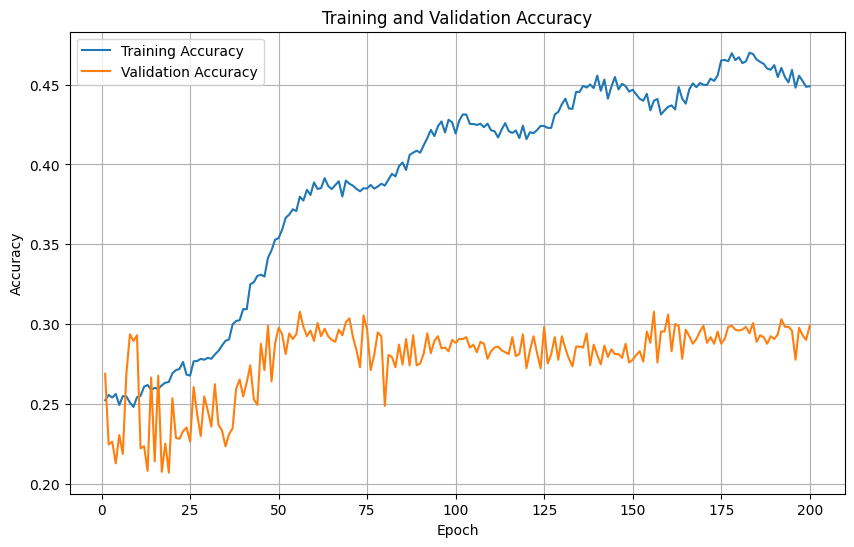

In [82]:
import matplotlib.pyplot as plt
n_epochs = number_epochs
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [83]:
end_time = time.time()
calc_time(end_time, start_time)
test_model(model, test_loader)

time to train model:   1.0 hours,   45.0 minutes,   37 seconds
Test acc: 0.266


In [84]:
torch.save(model, path_to_save+'gru')
torch.cuda.empty_cache()

# end

In [85]:
print('time i will never get back:')
hours = (end_time - super_start_time) // 3600
minutes = ((end_time - super_start_time) % 3600) // 60
seconds = (end_time - super_start_time) % 60

print(f'time to train models: \
{hours} hours, \
{minutes} minutes, \
{int(seconds)} seconds')

time i will never get back:
time to train models: 1.0 hours, 45.0 minutes, 37 seconds
